In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P', 3]


text_width = 5.5  # in  --> Confirmed with template explanation

fs_m1 = 4.5  # for figure ticks
fs = 7  # for regular figure text
fs_p1 = 8  # figure titles

axes_lw = 0.6

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath}'})

# Test setup

# plt.figure(dpi=400, figsize=(text_width, text_width/3))
# plt.grid(0.3, zorder=0)
# for i in range(10):
#     plt.bar(i, i + 1, color=f'C{i}', zorder=2)
#     # ^ This zorder nonsense makes the grid  lines go behid the bars. I don't know why this is needed for barplots, but shouldn't usually be needed.
# # plt.title(r'\textbf{Test}, $\mathcal{C}, \mathbb{R}$')
# plt.xlabel('test $x$')
# plt.ylabel('test $y$')
# plt.show()

# Define errorfill


def errorfill(x, y, yerr, color=None, alpha_fill=0.3, line_alpha=1, ax=None,
              lw=1, linestyle='-', fill_linewidths=0.2,
              marker=None, markersize=1, label=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    plt_return = ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=line_alpha, label=label, marker=marker, markersize=markersize)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    return plt_return


In [2]:
import wandb
api = wandb.Api()

results = {}


In [3]:
import pandas as pd

boundmodes = ['MCD_CAIS_UHA_sn', 'MCD_CAIS_sn', 'MCD_U_a-lp-sn', 'UHA', 'MCD_ULA_sn', 'MCD_ULA', 'SMC', 'DDS', 'PIS']
models = ['seeds', 'banana', 'brownian', 'lorenz', 'log_ionosphere', 'log_sonar', 'lgcp', 'funnel', 'gmm']
all_nbridges = [8, 16, 32, 64, 128, 256]
metrics = ['elbo', 'ln_Z']
metric_map = {'elbo_final': 'elbo', 'final_ln_Z': 'ln_Z'}

for bm in boundmodes:
    results[bm] = {}
    for model in models:
        results[bm][model] = {}
        for nbridge in all_nbridges:
            results[bm][model][nbridge] = {}


sweep = api.sweep("shreyaspadhy/cais/j6k6m55f")

# Have a list of sweeps and concatenate all runs
sweeps = [
    api.sweep("shreyaspadhy/cais/j6k6m55f"), # 6 targets, nbridges
    api.sweep("shreyaspadhy/cais/qz43axbj/"),  # LGCP
    api.sweep("shreyaspadhy/cais/t91018qt"),  # Lorenz 1st ordeer
    api.sweep("shreyaspadhy/cais/l2pwn13o"),  # Lorenz 2nd order
]
sweep_runs = []
for sweep in sweeps:
    sweep_runs.extend(sweep.runs)


df = pd.DataFrame([run.config for run in sweep_runs]).transpose()

rows = []
for run in sweep_runs:
    row = {'run_name': run.name}
    row.update(run.config)
    row.update(run.summary_metrics)
    rows.append(row)

df_new = pd.DataFrame(rows)

unique_boundmodes = df_new['boundmode'].unique()
unique_models = df_new['model'].unique()
unique_nbridges = df_new['nbridges'].unique()

print(unique_boundmodes)
print(unique_models)
print(unique_nbridges)

df_new = df_new[(df_new['model'] != 'lorenz') | (df_new['elbo_final'].notna())]


['MCD_CAIS_UHA_sn' 'MCD_CAIS_sn' 'MCD_U_a-lp-sn' 'UHA' 'MCD_ULA_sn'
 'MCD_ULA']
['seeds' 'banana' 'brownian' 'lorenz' 'log_ionosphere' 'log_sonar' 'lgcp']
[  8  32  16 128 256  64]


In [35]:
rows = []

for bm in unique_boundmodes:
    for model in unique_models:

        df_filtered = df_new[(df_new['boundmode'] == bm) & (df_new['model'] == model)]
        
        # Plot the elbo_final values for each nbridges value
        elbos, elbos_std = [], []
        metric_means, metric_stds = {}, {}
        for nbridge in sorted(unique_nbridges):
            for metric in ['elbo_final', 'final_ln_Z']:
                df_nbridge = df_filtered[df_filtered['nbridges'] == nbridge]

                # print(bm, model, nbridge, metric, df_nbridge[metric].values)
                if df_nbridge[metric].values.size == 0:
                    if elbos:
                        elbos.append(elbos[-1])
                        elbos_std.append(elbos_std[-1])
                    else:
                        elbos.append(np.nan)
                        elbos_std.append(0)
                    continue
                elif df_nbridge[metric].values.size > 1:
                    elbo_val_id = np.argmax(df_nbridge[metric].values)
                    elbo_val = df_nbridge[metric].values[elbo_val_id]
                    elbo_std_val = df_nbridge[metric + '_std'].values[elbo_val_id]
                    # print(elbo_val, elbo_std_val)
                    elbos.append(elbo_val)
                    elbos_std.append(elbo_std_val)
                    # all_elbos.append(elbo_val)
                else:
                    elbos.append(df_nbridge[metric].values[-1])
                    elbos_std.append(df_nbridge[metric + '_std'].values[-1])
                
                metric_means[metric] = elbos[-1]
                metric_stds[metric] = elbos_std[-1]
                # all_elbos.extend(df_nbridge[metric].values)
                
            row = {'boundmode': bm, 'model': model, 'nbridges': nbridge, 'elbo': metric_means['elbo_final'], 'ln_Z': metric_means['final_ln_Z'], 'elbo_std': metric_stds['elbo_final'], 'ln_Z_std': metric_stds['final_ln_Z']}
            rows.append(row)

df_base = pd.DataFrame(rows)


In [36]:
df_base

,boundmode,model,nbridges,elbo,ln_Z,elbo_std,ln_Z_std
0,MCD_CAIS_UHA_sn,seeds,8,-74.532913,-73.631546,0.062972,0.212163
1,MCD_CAIS_UHA_sn,seeds,16,-74.215393,-73.489838,0.042376,0.299340
2,MCD_CAIS_UHA_sn,seeds,32,-73.956375,-73.423416,0.030241,0.196243
3,MCD_CAIS_UHA_sn,seeds,64,-73.778748,-73.412460,0.032810,0.072533
4,MCD_CAIS_UHA_sn,seeds,128,-73.679115,-73.396873,0.033218,0.073968
...,...,...,...,...,...,...,...
247,MCD_ULA,lgcp,16,463.368774,485.854401,0.354629,3.011848
248,MCD_ULA,lgcp,32,475.963928,494.553192,0.322353,2.337834
249,MCD_ULA,lgcp,64,485.754517,501.333557,0.305594,2.068059
250,MCD_ULA,lgcp,128,493.242401,506.224426,0.304943,1.712759


In [37]:
# Load in funnel numbers

# For MCD_CAIS_sn
sweep = api.sweep("shreyaspadhy/cais/1wahqgdi")

funnel_rows = []
for run in sweep.runs:
    # print(run.summary_metrics.keys())
    row = {
        'boundmode': run.config['boundmode'], 
        'model': run.config['model'], 
        'nbridges': run.config['nbridges'], 
        'elbo':run.summary_metrics.get('elbo_final', None),
        'elbo_std': run.summary_metrics.get('elbo_final_std', None), 
        'ln_Z': run.summary_metrics.get('final_ln_Z', None),
        'ln_Z_std': run.summary_metrics.get('final_ln_Z_std', None),
        'W2': run.summary_metrics.get('w2_dist', None),
        'W2_std': run.summary_metrics.get('w2_dist_std', None),}
    print(row)
    funnel_rows.append(row)

# For DDS and PIS
sweep = api.sweep("shreyaspadhy/dds/77hp3536")
name_map = {'oudstl': 'DDS', 'pisstl': 'PIS'}

for run in sweep.runs:
    # print(run.summary_metrics.keys())
    row = {
        'boundmode': name_map[run.config['model.reference_process_key']], 
        'model': 'funnel', 
        'nbridges': int(run.config['model.tfinal'] / 0.05), 
        'elbo':run.summary_metrics.get('elbo_final', None),
        'elbo_std': run.summary_metrics.get('elbo_final_std', None), 
        'ln_Z': run.summary_metrics.get('final_ln_Z', None),
        'ln_Z_std': run.summary_metrics.get('final_ln_Z_std', None),
        'W2': run.summary_metrics.get('W2', None),
        'W2_std': run.summary_metrics.get('W2_std', None),}
    print(row)
    funnel_rows.append(row)
df_funnel = pd.DataFrame(funnel_rows)

{'boundmode': 'MCD_CAIS_sn', 'model': 'funnel', 'nbridges': 8, 'elbo': -1.062812566757202, 'elbo_std': 0.024624431505799297, 'ln_Z': -0.30369067192077637, 'ln_Z_std': 0.15074744820594788, 'W2': 0.002747848653625376, 'W2_std': 0.001586904038633556}
{'boundmode': 'MCD_CAIS_sn', 'model': 'funnel', 'nbridges': 32, 'elbo': -0.6807763576507568, 'elbo_std': 0.0199612844735384, 'ln_Z': -0.18054154515266416, 'ln_Z_std': 0.07773122191429138, 'W2': 0.0028213822746931106, 'W2_std': 0.0014248562973383254}
{'boundmode': 'MCD_CAIS_sn', 'model': 'funnel', 'nbridges': 256, 'elbo': -0.23042739927768707, 'elbo_std': 0.01369594968855381, 'ln_Z': -0.01933654211461544, 'ln_Z_std': 0.06369748711585999, 'W2': 0.0027218252002325547, 'W2_std': 0.0012500201358631297}
{'boundmode': 'MCD_CAIS_sn', 'model': 'funnel', 'nbridges': 128, 'elbo': -0.3427678048610687, 'elbo_std': 0.01543539483100176, 'ln_Z': -0.0572873130440712, 'ln_Z_std': 0.045246902853250504, 'W2': 0.002752190960561815, 'W2_std': 0.0013010679436796183

In [38]:
# Load in LGCP numbers

# For MCD_CAIS_sn
sweep = api.sweep("shreyaspadhy/cais/qz43axbj")

lgcp_rows = []
# for run in sweep.runs:
#     # print(run.summary_metrics.keys())
#     row = {
#         'boundmode': run.config['boundmode'], 
#         'model': run.config['model'], 
#         'nbridges': run.config['nbridges'], 
#         'elbo':run.summary_metrics.get('elbo_final', None),
#         'elbo_std': run.summary_metrics.get('elbo_final_std', None), 
#         'ln_Z': run.summary_metrics.get('final_ln_Z', None),
#         'ln_Z_std': run.summary_metrics.get('final_ln_Z_std', None),
#         'W2': run.summary_metrics.get('w2_dist', None),
#         'W2_std': run.summary_metrics.get('w2_dist_std', None),}
#     print(row)
#     lgcp_rows.append(row)

# For DDS and PIS
sweep = api.sweep("shreyaspadhy/dds/en5dqf1q")
name_map = {'oudstl': 'DDS', 'pisstl': 'PIS'}

for run in sweep.runs:
    # print(run.summary_metrics.keys())
    row = {
        'boundmode': name_map[run.config['model.reference_process_key']], 
        'model': 'lgcp', 
        'nbridges': int(run.config['model.tfinal'] / 0.05), 
        'elbo':run.summary_metrics.get('elbo_final', None),
        'elbo_std': run.summary_metrics.get('elbo_final_std', None), 
        'ln_Z': run.summary_metrics.get('final_ln_Z', None),
        'ln_Z_std': run.summary_metrics.get('final_ln_Z_std', None),
        'W2': run.summary_metrics.get('W2', None),
        'W2_std': run.summary_metrics.get('W2_std', None),}
    print(row)
    lgcp_rows.append(row)
df_lgcp = pd.DataFrame(lgcp_rows)

{'boundmode': 'PIS', 'model': 'lgcp', 'nbridges': 256, 'elbo': None, 'elbo_std': None, 'ln_Z': 507.09397176106773, 'ln_Z_std': 1.7886064682191254, 'W2': None, 'W2_std': None}
{'boundmode': 'PIS', 'model': 'lgcp', 'nbridges': 128, 'elbo': None, 'elbo_std': None, 'ln_Z': 503.1152628580729, 'ln_Z_std': 1.9172233108118968, 'W2': None, 'W2_std': None}
{'boundmode': 'PIS', 'model': 'lgcp', 'nbridges': 64, 'elbo': None, 'elbo_std': None, 'ln_Z': 499.9224049886068, 'ln_Z_std': 1.6517750201570585, 'W2': None, 'W2_std': None}
{'boundmode': 'PIS', 'model': 'lgcp', 'nbridges': 32, 'elbo': None, 'elbo_std': None, 'ln_Z': 478.3961985270182, 'ln_Z_std': 4.012228197475346, 'W2': None, 'W2_std': None}
{'boundmode': 'PIS', 'model': 'lgcp', 'nbridges': 16, 'elbo': None, 'elbo_std': None, 'ln_Z': 421.9878967285157, 'ln_Z_std': 3.6133762248126815, 'W2': None, 'W2_std': None}
{'boundmode': 'PIS', 'model': 'lgcp', 'nbridges': 8, 'elbo': None, 'elbo_std': None, 'ln_Z': 314.30255737304685, 'ln_Z_std': 5.689657

In [5]:
# Load in GMM numbers
import pandas as pd
from tqdm import tqdm

# For MCD_CAIS_sn
sweep = api.sweep("shreyaspadhy/cais/n2exqhfq")

gmm_rows = []

# elbos = {}

best_elbos = {}

for run in sweep.runs:
    model, boundmode, nbridges = run.config['model'], run.config['boundmode'], run.config['nbridges']
    key = (model, boundmode, nbridges)

    current_elbo = run.summary_metrics.get('elbo_final', float('-inf'))  # Default to negative infinity if not found
    # current_ln_Z = float('+inf') if current_ln_Z is None else current_ln_Z

    # current_unabs_ln_Z = run.summary_metrics.get('final_ln_Z', float('+inf'))
    # current_ln_Z = np.abs(run.summary_metrics.get('final_ln_Z', float('+inf')))  # Default to negative infinity if not found
    
    if key not in best_elbos or current_elbo > best_elbos[key]['elbo']:
        best_elbos[key] = {
            'boundmode': boundmode, 
            'model': model, 
            'nbridges': nbridges, 
            'elbo': current_elbo,
            'elbo_std': run.summary_metrics.get('elbo_final_std', None),
            'ln_Z': run.summary_metrics.get('final_ln_Z', None),
            'ln_Z_std': run.summary_metrics.get('final_ln_Z_std', None),
            'W2': run.summary_metrics.get('w2_dist', None),
            'W2_std': run.summary_metrics.get('w2_dist_std', None),
            'init_eps': run.config['init_eps'],
            'init_sigma': run.config['init_sigma'],
            'train_vi': run.config['train_vi'],
            'lr': run.config['lr'],
        }

# Convert the best_elbos dictionary values to a pandas DataFrame
df_gmm = pd.DataFrame(list(best_elbos.values()))

print(df_gmm)

# For DDS and PIS
sweep = api.sweep("shreyaspadhy/dds/2kjqm3xx")
name_map = {'oudstl': 'DDS', 'pisstl': 'PIS'}

reverse_name_map = {v: k for k, v in name_map.items()}

best_elbos = {}

for run in tqdm(sweep.runs):
    boundmode = name_map[run.config['model.reference_process_key']]
    nbridges = int(run.config['model.tfinal'] / 0.05)
    key = (boundmode, nbridges)
    
    # current_ln_Z = run.summary_metrics.get('final_ln_Z', float('-inf'))  # Default to negative infinity if not found
    # elbo_results = run.history()['elbo_results_eval/loss']
    history = run.history(keys=["elbo_results_eval/loss"])


    elbo_results = [row["elbo_results_eval/loss"] for i, row in history.iterrows() if row["elbo_results_eval/loss"] is not None]
    current_elbo = np.mean(elbo_results)
    elbo_std = np.std(elbo_results)
    # print(elbo_results.values)
    
    if key not in best_elbos or current_elbo < best_elbos[key]['elbo']:
        best_elbos[key] = {
            'boundmode': boundmode, 
            'model': 'gmm', 
            'nbridges': nbridges, 
            'elbo': current_elbo,
            'elbo_std': elbo_std,
            'ln_Z': run.summary_metrics.get('final_ln_Z', None),
            'ln_Z_std': run.summary_metrics.get('final_ln_Z_std', None),
            'W2': run.summary_metrics.get('W2', None),
            'W2_std': run.summary_metrics.get('W2_std', None),
            'model.sigma': run.config['model.sigma'],
            'model.alpha': run.config['model.alpha']
        }

# Convert the best_ln_Z dictionary values to a pandas DataFrame
df_ln_Z = pd.DataFrame(list(best_elbos.values()))

# Print out the configurations for each bound mode and number of bridges
configurations = df_ln_Z[['boundmode', 'nbridges', 'model.sigma', 'model.alpha']]

# Mockup return (replace with the actual DataFrame in your environment)
configurations

df_ln_Z


     boundmode model  nbridges      elbo  elbo_std      ln_Z  ln_Z_std  \
0  MCD_CAIS_sn   gmm         8 -0.693740  0.052487 -0.135778  0.083490   
1  MCD_CAIS_sn   gmm        16 -1.061035  0.084515 -0.013311  0.129186   
2  MCD_CAIS_sn   gmm        32 -0.765515  0.052515  0.009537  0.049556   
3  MCD_CAIS_sn   gmm        64 -0.583361  0.043236  0.007365  0.047696   
4  MCD_CAIS_sn   gmm       128 -0.504738  0.052094 -0.000479  0.036820   
5  MCD_CAIS_sn   gmm       256 -0.481074  0.044098 -0.008178  0.052059   

         W2    W2_std  init_eps  init_sigma  train_vi     lr  
0  0.024435  0.003735      0.01           2      True  0.001  
1  0.029195  0.003173      0.05           1      True  0.001  
2  0.028859  0.003619      0.01           2      True  0.001  
3  0.025016  0.002853      0.01           2      True  0.001  
4  0.026977  0.002801      0.01           2      True  0.001  
5  0.028829  0.003196      0.01           2     False  0.001  


 26%|██▌       | 77/300 [00:15<00:44,  5.02it/s]


KeyboardInterrupt: 

In [194]:
# Load in GMM numbers
from tqdm import tqdm

# For MCD_CAIS_sn
sweep = api.sweep("shreyaspadhy/cais/24wsukx8")

gmm_rows = []

# elbos = {}

best_elbos = {}

for run in sweep.runs:
    model, boundmode, nbridges = run.config['model'], run.config['boundmode'], run.config['nbridges']
    key = (model, boundmode, nbridges)

    current_elbo = run.summary_metrics.get('elbo_final', float('-inf'))  # Default to negative infinity if not found
    current_elbo = current_elbo if current_elbo is not None else float('-inf')
    print(current_elbo)
    #  current_ln_Z = float('+inf') if current_ln_Z is None else current_ln_Z

    # current_unabs_ln_Z = run.summary_metrics.get('final_ln_Z', float('+inf'))
    # current_ln_Z = np.abs(run.summary_metrics.get('final_ln_Z', float('+inf')))  # Default to negative infinity if not found
    
    if key not in best_elbos or current_elbo > best_elbos[key]['elbo']:
        best_elbos[key] = {
            'boundmode': boundmode, 
            'model': model, 
            'nbridges': nbridges, 
            'elbo': current_elbo,
            'elbo_std': run.summary_metrics.get('elbo_final_std', None),
            'ln_Z': run.summary_metrics.get('final_ln_Z', None),
            'ln_Z_std': run.summary_metrics.get('final_ln_Z_std', None),
            'W2': run.summary_metrics.get('w2_dist', None),
            'W2_std': run.summary_metrics.get('w2_dist_std', None),
            'init_eps': run.config['init_eps'],
            'init_sigma': run.config['init_sigma'],
            'train_vi': run.config['train_vi']
        }

# Convert the best_elbos dictionary values to a pandas DataFrame
df_gmm = pd.DataFrame(list(best_elbos.values()))

print(df_gmm)

# For DDS and PIS
sweep = api.sweep("shreyaspadhy/dds/cto499fp")
name_map = {'oudstl': 'DDS', 'pisstl': 'PIS'}

reverse_name_map = {v: k for k, v in name_map.items()}

best_elbos = {}

for run in tqdm(sweep.runs):
    boundmode = name_map[run.config['model.reference_process_key']]
    nbridges = int(run.config['model.tfinal'] / 0.05)
    key = (boundmode, nbridges)
    
    # current_ln_Z = run.summary_metrics.get('final_ln_Z', float('-inf'))  # Default to negative infinity if not found
    # elbo_results = run.history()['elbo_results_eval/loss']
    history = run.history(keys=["elbo_results_eval/loss"])


    elbo_results = [row["elbo_results_eval/loss"] for i, row in history.iterrows() if row["elbo_results_eval/loss"] is not None]
    current_elbo = np.mean(elbo_results)
    elbo_std = np.std(elbo_results)
    # print(elbo_results.values)
    
    if key not in best_elbos or current_elbo < best_elbos[key]['elbo']:
        best_elbos[key] = {
            'boundmode': boundmode, 
            'model': 'gmm', 
            'nbridges': nbridges, 
            'elbo': current_elbo,
            'elbo_std': elbo_std,
            'ln_Z': run.summary_metrics.get('final_ln_Z', None),
            'ln_Z_std': run.summary_metrics.get('final_ln_Z_std', None),
            'W2': run.summary_metrics.get('W2', None),
            'W2_std': run.summary_metrics.get('W2_std', None),
            'model.sigma': run.config['model.sigma'],
            'model.alpha': run.config['model.alpha']
        }

# Convert the best_ln_Z dictionary values to a pandas DataFrame
df_ln_Z = pd.DataFrame(list(best_elbos.values()))

# Print out the configurations for each bound mode and number of bridges
configurations = df_ln_Z[['boundmode', 'nbridges', 'model.sigma', 'model.alpha']]

# Mockup return (replace with the actual DataFrame in your environment)
configurations

df_ln_Z


-20.394371032714844
-inf
-inf
-48.61671829223633
-31.89337730407715
-87.04820251464844
-85.64140319824219
-inf
-161.10157775878906
-161.0222930908203
-inf
-inf
-16.73814582824707
-15.533781051635742
-26.797542572021484
-28.001554489135746
-43.73695755004883
-43.0505256652832
-80.16410827636719
-80.3443374633789
-150.22865295410156
-152.26283264160156
-292.8006896972656
-292.8006896972656
-11.297239303588867
-14.699356079101562
-24.094379425048828
-23.894163131713867
-39.87147521972656
-47.963584899902344
-73.70380401611328
-72.0188217163086
-138.28610229492188
-136.2161102294922
-265.2487487792969
-265.2487487792969
-1.3893882036209106
-1.4247690439224243
-1.30033278465271
-1.1792057752609253
-1.2416645288467407
-1.2612202167510986
-1.2339786291122437
-1.2600016593933103
-1.7239317893981934
-2.9509735107421875
-2.9521589279174805
-1.7869538068771362
-1.2727493047714231
-1.091702938079834
-1.3161555528640747
-1.040213942527771
-1.240706443786621
-1.0442699193954468
-1.0580823421478271
-

100%|██████████| 300/300 [02:13<00:00,  2.25it/s]


,boundmode,model,nbridges,elbo,elbo_std,ln_Z,ln_Z_std,W2,W2_std,model.sigma,model.alpha
0,PIS,gmm,256,2.074877,0.081503,-0.022915,0.086181,0.031507,0.003574,0.5,2.0
1,PIS,gmm,128,2.292342,0.072790,-0.043139,0.168356,0.044832,0.006097,0.5,1.0
2,PIS,gmm,64,2.829401,0.048519,-0.141408,0.549404,0.065128,0.007799,0.5,0.5
3,PIS,gmm,32,3.408361,0.094525,-0.057085,0.114689,0.044542,0.004642,1.0,1.5
4,PIS,gmm,8,3.378659,0.060072,-0.100062,0.368143,0.061845,0.008226,1.5,1.5
5,PIS,gmm,16,3.277421,0.065423,-0.290952,0.272125,0.065193,0.008705,1.0,2.0
6,DDS,gmm,256,3.151571,0.071511,-0.212715,0.230406,0.058057,0.006468,1.0,0.5
7,DDS,gmm,128,3.131397,0.065247,-0.184310,0.231972,0.058946,0.006547,1.0,0.5
8,DDS,gmm,64,3.154066,0.071045,-0.223472,0.251872,0.057666,0.007293,1.0,1.0
9,DDS,gmm,8,3.192501,0.063785,-0.158655,0.217276,0.059084,0.007899,1.0,2.0


In [151]:
import pickle
elbos = pickle.load(open('ELBO.pkl', 'rb'))

ln_Zs = pickle.load(open('log Z.pkl', 'rb'))

W2_s = pickle.load(open('w2_dist.pkl', 'rb'))

models_map = {'log_sonar': 'sonar_T', 
              'log_ionosphere': 'ionosphere_T', 
              'seeds': 'seeds_T',
              'brownian': 'brownian_T', 
              'lorenz': 'lorenz_T',
              'lgcp': 'lgcp_T',
              'funnel': 'funnel_T',
              'gmm': 'gmm_T',
              'lgcp': 'lgcp_T',}

rows = []

for model in models_to_plot:
    for nbridge in sorted(all_nbridges):
        elbo_vals = elbos[models_map[model]][str(nbridge)]
        elbo_mean, elbo_std = np.mean(elbo_vals), np.std(elbo_vals)
        ln_Z_vals = ln_Zs[models_map[model]][str(nbridge)]
        ln_Z_mean, ln_Z_std = np.mean(ln_Z_vals), np.std(ln_Z_vals)
        try:
            W2_vals = W2_s[models_map[model]][str(nbridge)]
            W2_mean, W2_std = np.mean(W2_vals), np.std(W2_vals)
        except:
            W2_mean, W2_std = np.nan, np.nan
        row = {
            'boundmode': 'smc', 
            'model': model,
            'nbridges': nbridge, 
            'elbo': elbo_mean,
            'elbo_std': elbo_std,
            'ln_Z': ln_Z_mean,
            'ln_Z_std': ln_Z_std,
            'W2': W2_mean,
            'W2_std': W2_std,
        }
        rows.append(row)
df_smc = pd.DataFrame(rows)

df_smc

,boundmode,model,nbridges,elbo,elbo_std,ln_Z,ln_Z_std,W2,W2_std
0,smc,log_sonar,8,-178.188853,2.953677,-116.983380,4.202652,NaN,NaN
1,smc,log_sonar,16,-137.436834,1.743784,-110.427018,1.924897,NaN,NaN
2,smc,log_sonar,32,-120.540005,0.576745,-108.543256,0.522532,NaN,NaN
3,smc,log_sonar,64,-113.824540,0.162011,-108.413024,0.149046,NaN,NaN
4,smc,log_sonar,128,-110.902447,0.088436,-108.399044,0.083118,NaN,NaN
5,smc,log_sonar,256,-109.565048,0.070381,-108.372423,0.069588,NaN,NaN
6,smc,log_ionosphere,8,-204.465166,2.877144,-123.762662,3.507117,NaN,NaN
7,smc,log_ionosphere,16,-149.192869,1.163074,-113.575784,1.386076,NaN,NaN
8,smc,log_ionosphere,32,-127.997774,0.390741,-112.093495,0.513748,NaN,NaN
9,smc,log_ionosphere,64,-118.835418,0.191374,-111.735768,0.184574,NaN,NaN


In [208]:
import pickle
elbos = pickle.load(open('ELBO.pkl', 'rb'))

ln_Zs = pickle.load(open('craft_log Z.pkl', 'rb'))

W2_s = pickle.load(open('craft_w2_dist.pkl', 'rb'))

print(ln_Zs['gmm'].keys())
models_map = {
    # 'log_sonar': 'sonar_T', 
            #   'log_ionosphere': 'ionosphere_T', 
            #   'seeds': 'seeds_T',
            #   'brownian': 'brownian_T', 
            #   'lorenz': 'lorenz_T',
            #   'lgcp': 'lgcp_T',
              'funnel': 'funnel',
              'gmm': 'gmm',
            #   'lgcp': 'lgcp_T',
              }

rows = []

for model in models_map.keys():
    for nbridge in sorted(all_nbridges):
        # elbo_vals = elbos[models_map[model]][str(nbridge)]
        # elbo_mean, elbo_std = np.mean(elbo_vals), np.std(elbo_vals)
        ln_Z_vals = ln_Zs[models_map[model]][str(nbridge // 4)]
        ln_Z_mean, ln_Z_std = np.mean(ln_Z_vals), np.std(ln_Z_vals)
        try:
            W2_vals = W2_s[models_map[model]][str(nbridge // 4)]
            W2_mean, W2_std = np.mean(W2_vals), np.std(W2_vals)
        except:
            W2_mean, W2_std = np.nan, np.nan
        row = {
            'boundmode': 'craft', 
            'model': model,
            'nbridges': nbridge, 
            'elbo': None,
            'elbo_std': None,
            'ln_Z': ln_Z_mean,
            'ln_Z_std': ln_Z_std,
            'W2': W2_mean,
            'W2_std': W2_std,
        }
        rows.append(row)
df_craft = pd.DataFrame(rows)

df_craft

dict_keys(['2', '4', '8', '16', '32', '64'])


,boundmode,model,nbridges,elbo,elbo_std,ln_Z,ln_Z_std,W2,W2_std
0,craft,funnel,8,None,None,-0.979014,0.288855,23.089378,0.064721
1,craft,funnel,16,None,None,-0.308665,0.233070,22.884458,0.118436
2,craft,funnel,32,None,None,-0.114308,0.350323,22.948574,0.408055
3,craft,funnel,64,None,None,-0.035373,0.406605,23.287636,1.697554
4,craft,funnel,128,None,None,-0.143374,0.122013,22.846493,0.479270
5,craft,funnel,256,None,None,-0.118739,0.102078,22.769703,0.490360
6,craft,gmm,8,None,None,-0.038521,0.544720,1.916881,0.575193
7,craft,gmm,16,None,None,0.011556,0.087369,1.670874,0.077846
8,craft,gmm,32,None,None,-0.010742,0.040561,1.656604,0.067149
9,craft,gmm,64,None,None,0.002032,0.025984,1.622355,0.060780


In [293]:
import pickle
elbos = pickle.load(open('aft_ELBO.pkl', 'rb'))

ln_Zs = pickle.load(open('aft_log Z (1).pkl', 'rb'))

W2_s = pickle.load(open('aft_w2_dist (1).pkl', 'rb'))

print(ln_Zs['funnel_T'].keys())
models_map = {
    # 'log_sonar': 'sonar_T', 
            #   'log_ionosphere': 'ionosphere_T', 
            #   'seeds': 'seeds_T',
            #   'brownian': 'brownian_T', 
            #   'lorenz': 'lorenz_T',
            #   'lgcp': 'lgcp_T',
              'funnel': 'funnel_T',
              'gmm': 'gmm_T',
            #   'lgcp': 'lgcp_T',
              }

rows = []

for model in models_map.keys():
    for nbridge in sorted(all_nbridges):
        elbo_vals = elbos[models_map[model]][str(nbridge)]
        elbo_mean, elbo_std = np.mean(elbo_vals), np.std(elbo_vals)
        ln_Z_vals = ln_Zs[models_map[model]][str(nbridge)]
        ln_Z_mean, ln_Z_std = np.mean(ln_Z_vals), np.std(ln_Z_vals)
        try:
            W2_vals = W2_s[models_map[model]][str(nbridge)]
            W2_mean, W2_std = np.mean(W2_vals), np.std(W2_vals)
        except:
            W2_mean, W2_std = np.nan, np.nan
        row = {
            'boundmode': 'aft', 
            'model': model,
            'nbridges': nbridge, 
            'elbo': elbo_mean,
            'elbo_std': elbo_std,
            'ln_Z': ln_Z_mean,
            'ln_Z_std': ln_Z_std,
            'W2': W2_mean,
            'W2_std': W2_std,
        }
        rows.append(row)
df_aft = pd.DataFrame(rows)

df_aft

dict_keys(['8', '16', '32', '64', '128', '256'])


,boundmode,model,nbridges,elbo,elbo_std,ln_Z,ln_Z_std,W2,W2_std
0,aft,funnel,8,-0.862707,0.124381,-0.344444,0.272856,0.001534,0.001604
1,aft,funnel,16,-0.531489,0.335749,-0.159047,0.605388,0.001309,0.001438
2,aft,funnel,32,-0.462853,0.076696,-0.280874,0.113969,0.002040,0.001834
3,aft,funnel,64,-0.343401,0.135551,-0.235999,0.174851,0.002815,0.001891
4,aft,funnel,128,-0.235528,0.295559,-0.164761,0.335311,0.003325,0.001747
5,aft,funnel,256,-0.242944,0.111033,-0.199993,0.117291,0.003464,0.001703
6,aft,gmm,8,-0.342969,0.045625,0.003362,0.049069,0.023559,0.001410
7,aft,gmm,16,-0.200542,0.027634,-0.011232,0.020172,0.023982,0.001336
8,aft,gmm,32,-0.117461,0.020043,0.000523,0.018812,0.023908,0.000821
9,aft,gmm,64,-0.080136,0.022188,-0.001075,0.016679,0.023359,0.001015


In [298]:
df = pd.concat([df_base, df_funnel, df_lgcp, df_gmm, df_ln_Z, df_smc, df_craft, df_aft])

# Set a specific value manually

df.loc[(df['boundmode'] == 'MCD_ULA') & (df['model'] == 'brownian') & (df['nbridges'] == 128), 'elbo'] = -0.49
df.loc[(df['boundmode'] == 'MCD_ULA') & (df['model'] == 'brownian') & (df['nbridges'] == 128), 'elbo_std'] = -0.1
# Save the df
df.to_pickle('final_results.pkl')

In [4]:
# Load the df from pickle
df = pd.read_pickle('final_results.pkl')

pos :   Bbox(x0=0.125, y0=0.6283333333333334, x1=0.3824750830564784, y1=0.88)
[-122.49563599 -119.96590424 -117.47381592 -115.27601624 -113.41619873
 -111.98737335 -118.25031281 -114.42493439 -113.59672546 -111.10757446
 -110.18201447 -110.06459045 -112.27394867 -110.90386963 -110.45916748
 -109.50298309 -109.60771179 -109.25032043 -120.02534485 -116.73267365
 -113.99517822 -111.97272491 -110.57172394 -109.74220276 -116.27470398
 -112.9741745  -110.89886475 -110.03962708 -109.11083984 -109.04875183
 -113.07781982 -110.93982697 -109.78481293 -109.27764893 -109.02064514
 -108.90364075]
pos :   Bbox(x0=0.125, y0=0.3766666666666667, x1=0.3824750830564784, y1=0.6283333333333334)
[-116.39800262 -115.43388367 -114.47733307 -113.74694824 -113.17073059
 -112.70966339 -114.9471817  -113.9781723  -113.22728729 -112.69901276
 -112.32484436 -111.96979523 -113.21065521 -112.64269257 -112.64269257
 -112.22045898 -111.9799881  -111.92455292 -115.61966705 -114.38246155
 -113.41613007 -112.73987579 -112

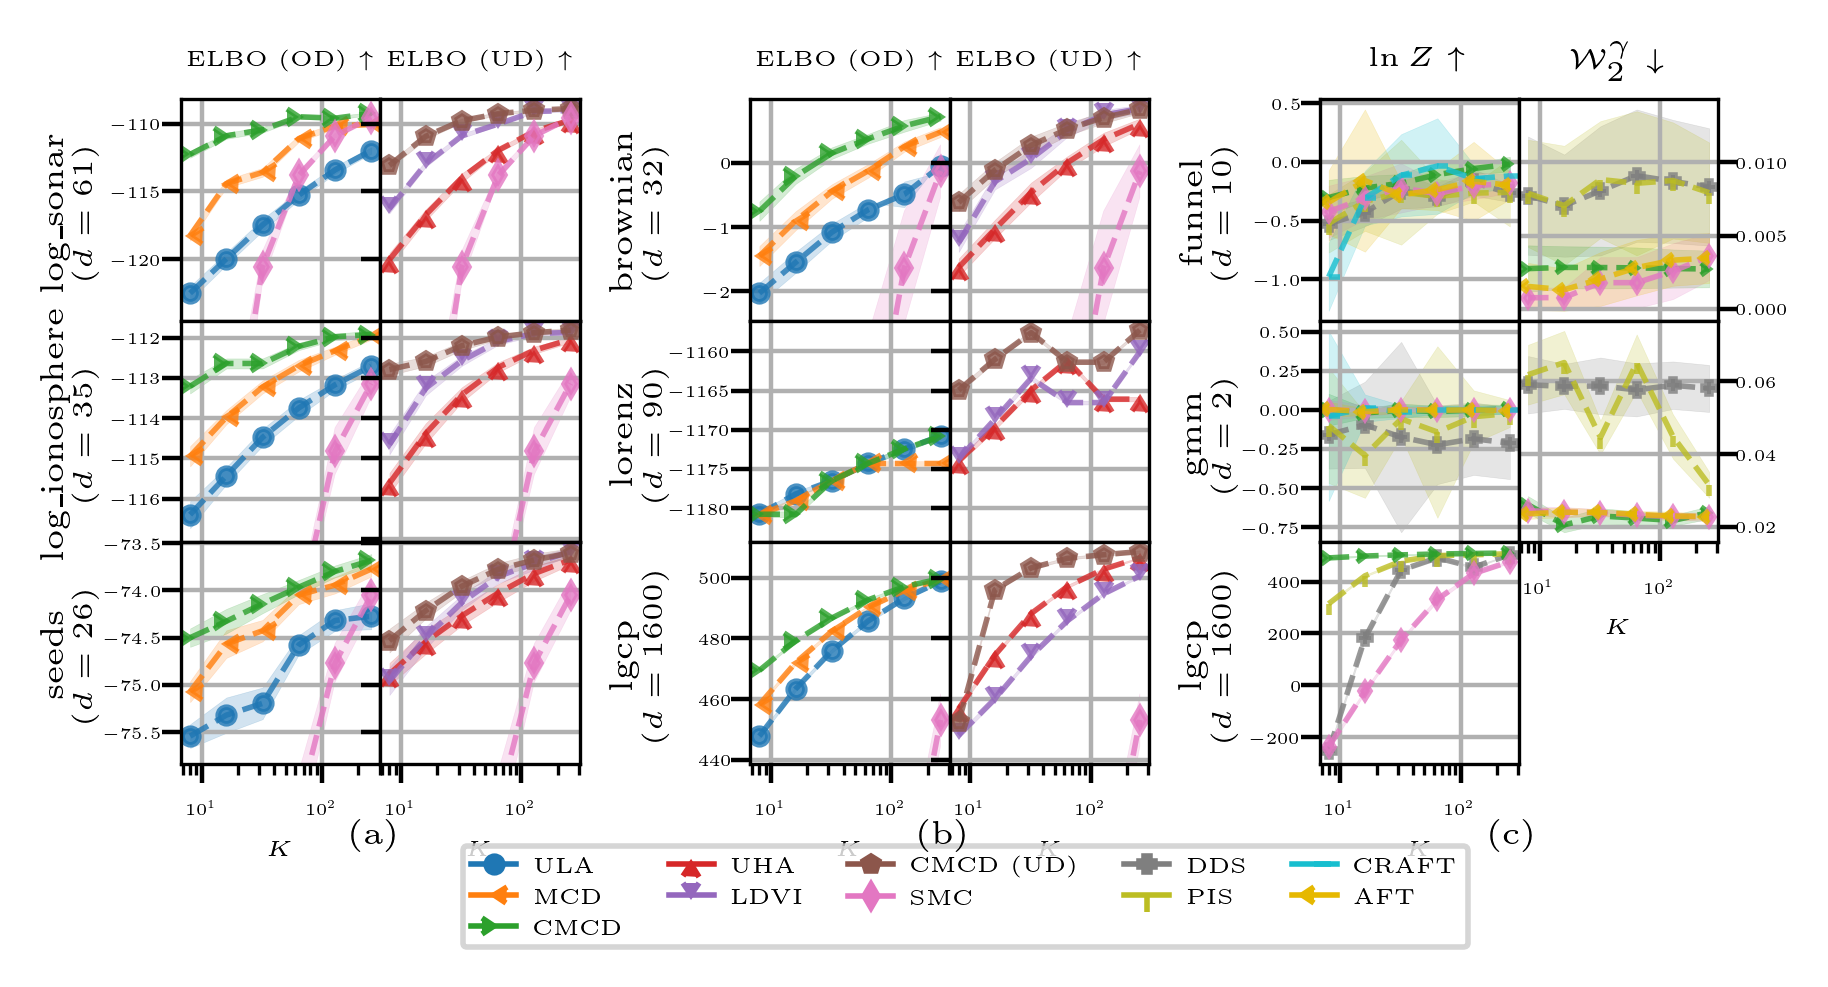

In [7]:

boundmodes_to_plot_1st = ['MCD_ULA', 'MCD_ULA_sn', 'MCD_CAIS_sn', 'smc']
boundmodes_to_plot_2nd = ['UHA', 'MCD_U_a-lp-sn', 'MCD_CAIS_UHA_sn', 'smc']

boundmodes_ln_Z = ['DDS', 'PIS', 'MCD_CAIS_sn', 'smc', 'craft', 'aft']

models_to_plot = ['log_sonar', 'log_ionosphere', 'seeds', 'brownian', 'lorenz', 'lgcp', 'funnel', 'gmm', 'lgcp']

dims = {
    'log_sonar': 61, 'log_ionosphere': 35, 'seeds': 26, 'brownian': 32, 'lorenz': 90, 'funnel': 10, 'gmm': 2, 'lgcp': 1600
}

models_with_ln_Z = ['funnel', 'gmm', 'lgcp', 'smc']

fig, axs_outer = plt.subplots(3, 3, figsize=(1.0 * text_width, 0.4 * text_width), dpi=400)  # adjust figsize as needed

legend_names = {'MCD_ULA': 'ULA', 'MCD_ULA_sn': 'MCD', 'MCD_CAIS_sn': 'CMCD', 'UHA': 'UHA', 
                'MCD_U_a-lp-sn': 'LDVI', 'MCD_CAIS_UHA_sn': 'CMCD (UD)', 'smc': 'SMC',
                'DDS': 'DDS', 'PIS': 'PIS', 'craft': 'CRAFT', 'aft': 'AFT'}

color_maps = {'MCD_ULA': 0, 'MCD_ULA_sn': 1, 'MCD_CAIS_sn': 2, 'UHA': 3, 
                'MCD_U_a-lp-sn': 4, 'MCD_CAIS_UHA_sn': 5, 'smc': 6,
                'DDS': 7, 'PIS': 8, 'craft': 9, 'aft': 10}

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', "#e6b800"]

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P', 3, 1, 8]

fs_m1 = 3
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
# marker_maps = {'MCD_ULA'}

plt.subplots_adjust(wspace=0.005, hspace=0.0)
# plt.locator_params(axis='y', nbins=5)

for i in range(3):
    for j in range(3):
        axs_outer[i, j].axis('off')

for outer_i in range(3):
    for outer_j in range(3):
        model_idx = 3 * outer_i + outer_j
        if model_idx >= len(models_to_plot):
            continue
        model = models_to_plot[model_idx]

        axs_outer[outer_i][outer_j].set_aspect('equal')

        axs_0 = axs_outer[outer_j][outer_i].inset_axes([0, 0, 0.9, 1])
        axs_1 = axs_outer[outer_j][outer_i].inset_axes([0.9, 0, 0.9, 1])

        # if outer_i == 2 and outer_j == 2:
        #     fig.delaxes(axs_1)
        # plt.figtext(-0.2, 0.25 + 0.25 * i, model, rotation=90, va='center', ha='center')

        # Using plt.figtext, we can add text to the figure of each model to left of y-axis
        pos = axs_outer[outer_j][outer_i].get_position(original=True)
        print(f'pos :  ', pos)
        label = '\texttt{' + model + '}'
        plt.figtext(pos.x0 + 0.021, pos.y0 + (pos.y1 - pos.y0) / 2, model, rotation=90, va='center', ha='center', fontsize=6)
        plt.figtext(pos.x0 + 0.035, pos.y0 + (pos.y1 - pos.y0) / 2, rf'($d = {dims[model]}$)', rotation=90, va='center', ha='center', fontsize=5)

        if outer_i == 0:
            label_id = '(a)'
        elif outer_i == 1:
            label_id = '(b)'
        elif outer_i == 2:
            label_id = '(c)'
        
        if outer_j == 2:
            plt.figtext(pos.x0 + 0.65 * (pos.x1- pos.x0), pos.y0 - 0.08, label_id, va='center', ha='center', fontsize=6)
            # plt.figtext(pos.x0 + 0.015, pos.y0 + (pos.y1 - pos.y0) / 2, r'ELBO $\rightarrow$', rotation=90, va='center', ha='center', fontsize=5)

        if outer_i == 2:
            # plt.figtext(pos.x0 + 0.015, pos.y0 + (pos.y1 - pos.y0) / 2, r'$\ln Z \rightarrow$', rotation=90, va='center', ha='center', fontsize=5)
            # plt.figtext(pos.x1 + 0.035, pos.y0 + (pos.y1 - pos.y0) / 2, r'W2 $\leftarrow$', rotation=90, va='center', ha='center', fontsize=5)
            pass

        # else:(
        #     plt.figtextpos.x0, pos.y0 + (pos.y1 - pos.y0) / 2, model, rotation=90, va='center', ha='center')
        # Make figtext to left of each y-axis label
        # axs_outer[outer_j][outer_i].text(0.1, 0.5, model, rotation=90, va='center', ha='center')

        
        # if outer_j == 2:
        axs_0.set_xscale('log')
        axs_1.set_xscale('log')

        # axs_0.locator_params(axis='y', nbins=5)
        # axs_1.locator_params(axis='y', nbins=5)

            # axs_0.set_xticks([8, 32, 64, 128, 256])
            # axs_1.set_xticks([8, 32, 64, 128, 256])
        if outer_j != 2:
            axs_0.set_xticklabels([])
            if outer_j == 1 and outer_i == 0:
                axs_1.set_xticklabels([])
        
        if outer_i == 2:
            axs_1.yaxis.tick_right()
        else:
            axs_1.set_yticklabels([])

        if outer_j == 1 and outer_i == 0:
            axs_0.set_yticks([-116, -115, -114, -113, -112])
        
        if outer_j == 2:
            axs_0.set_xlabel(r'$K$', fontsize=4)
            axs_1.set_xlabel(r'$K$', fontsize=4)
        
        if outer_j == 1 and outer_i == 2:
            axs_1.set_xlabel(r'$K$', fontsize=4)
        
        axs_0.yaxis.set_tick_params(pad=-0.3)

        if outer_i == 2:
            axs_1.yaxis.set_tick_params(pad=-0.3)

        # if outer_
        # axs_1.set_yticks([])
        # axs_outer[outer_i][outer_j].subplots(1, 2, sharey=True, figsize=(0.9 * text_width, 0.5 * text_width), dpi=400)  # adjust figsize as needed
        all_elbos, all_lns = [], []
        if (model not in models_with_ln_Z) or (model == 'lgcp' and outer_i == 1):
            for j, boundmode in enumerate(boundmodes_to_plot_1st):
                elbos, elbos_std = [], []
                for nbridge in sorted(unique_nbridges):
                    df_filtered = df[(df['boundmode'] == boundmode) & (df['model'] == model) & (df['nbridges'] == nbridge)]
                    # print(boundmode, model, nbridge, df_filtered['elbo'].values)
                    elbos.append(df_filtered['elbo'].values[-1])
                    elbos_std.append(df_filtered['elbo_std'].values[-1])
                    if boundmode != 'smc':
                        all_elbos.append(elbos[-1])

                elbos, elbos_std = np.squeeze(np.array(elbos)), np.squeeze(np.array(elbos_std))

                errorfill(sorted(unique_nbridges), elbos, 2 * elbos_std, 
                        color=c[color_maps[boundmode]], alpha_fill=0.2, line_alpha=0.8,
                        ax=axs_0, lw=1, linestyle='--', 
                        fill_linewidths=0.1, marker=markerlist[color_maps[boundmode]], markersize=3, 
                        label=legend_names[boundmode])
            
            for j, boundmode in enumerate(boundmodes_to_plot_2nd):

                # Plot the elbo_final values for each nbridges value
                elbos, elbos_std = [], []
                for nbridge in sorted(unique_nbridges):
                    # print(boundmode, model, nbridge)
                    # Get the correct DF
                    df_filtered = df[(df['boundmode'] == boundmode) & (df['model'] == model) & (df['nbridges'] == nbridge)]
                    # print(boundmode, model, nbridge, df_filtered['elbo'].values)
                    elbos.append(df_filtered['elbo'].values[-1])
                    elbos_std.append(df_filtered['elbo_std'].values[-1])
                    if boundmode != 'smc':
                        all_elbos.append(elbos[-1])

                elbos, elbos_std = np.squeeze(np.array(elbos)), np.squeeze(np.array(elbos_std))
                # print(elbos, elbos_std)

                errorfill(sorted(unique_nbridges), elbos, 2 * elbos_std, 
                        color=c[color_maps[boundmode]], alpha_fill=0.2, line_alpha=0.8,
                        ax=axs_1, lw=1, linestyle='--', 
                        fill_linewidths=0.1, marker=markerlist[color_maps[boundmode]], markersize=3, 
                        label=legend_names[boundmode])
            
            if outer_j == 0:
                axs_0.set_title(r'ELBO (OD) $\uparrow$ ', fontsize=4)
                axs_1.set_title(r'ELBO (UD) $\uparrow$', fontsize=4)
                
        else:
            for j, boundmode in enumerate(boundmodes_ln_Z):
                if model == 'lgcp' and boundmode in ['craft', 'aft']:
                    continue
                elbos, elbos_std = [], []
                for nbridge in sorted(unique_nbridges):
                    df_filtered = df[(df['boundmode'] == boundmode) & (df['model'] == model) & (df['nbridges'] == nbridge)]
                    # print(boundmode, model, nbridge, df_filtered['ln_Z'].values)
                    print(boundmode, model, nbridge)
                    elbos.append(df_filtered['ln_Z'].values[-1])
                    elbos_std.append(df_filtered['ln_Z_std'].values[-1])
                    all_lns.append(elbos[-1])

                elbos, elbos_std = np.squeeze(np.array(elbos)), np.squeeze(np.array(elbos_std))

                errorfill(sorted(unique_nbridges), elbos, elbos_std, 
                        color=c[color_maps[boundmode]], alpha_fill=0.2, line_alpha=0.8,
                        ax=axs_0, lw=1, linestyle='--', 
                        fill_linewidths=0.1, marker=markerlist[color_maps[boundmode]], markersize=2, 
                        label=legend_names[boundmode])
            
            for j, boundmode in enumerate(boundmodes_ln_Z):
                if (model in ['lgcp', 'funnel', 'gmm'] and boundmode in ['craft']) or (model == 'lgcp' and boundmode in ['aft']):
                    continue
                # Plot the elbo_final values for each nbridges value
                elbos, elbos_std = [], []
                for nbridge in sorted(unique_nbridges):
                    # print(boundmode, model, nbridge)
                    # Get the correct DF
                    df_filtered = df[(df['boundmode'] == boundmode) & (df['model'] == model) & (df['nbridges'] == nbridge)]
                    print(boundmode, model, nbridge)
                    elbos.append(df_filtered['W2'].values[-1])
                    elbos_std.append(df_filtered['W2_std'].values[-1])
                    all_lns.append(elbos[-1])

                elbos, elbos_std = np.squeeze(np.array(elbos)), np.squeeze(np.array(elbos_std))
                # print(elbos, elbos_std)

                elbos, elbos_std = np.nan_to_num(elbos), np.nan_to_num(elbos_std)
                if model == 'lgcp':
                    continue
                errorfill(sorted(unique_nbridges), elbos, elbos_std, 
                    color=c[color_maps[boundmode]], alpha_fill=0.2, line_alpha=0.8,
                    ax=axs_1, lw=1, linestyle='--', 
                    fill_linewidths=0.1, marker=markerlist[color_maps[boundmode]], markersize=2, 
                    label=legend_names[boundmode])
                
            if outer_i == 2 and outer_j == 2:
                axs_1.axis('off')    
            if outer_j == 0:
                axs_0.set_title(r'$\ln Z \uparrow$', fontsize=5)
                axs_1.set_title(r'$\mathcal{W}_2^{\gamma} \downarrow$', fontsize=5)
        
        if outer_i != 2:
            all_elbos = np.nan_to_num(np.array(all_elbos))
            print(all_elbos)
            global_min, global_max = np.min(all_elbos), np.max(all_elbos)
            axs_0.set_ylim(global_min - 0.15 * (global_max - global_min), global_max + 0.05 * (global_max - global_min))
            axs_1.set_ylim(global_min - 0.15 * (global_max - global_min), global_max + 0.05 * (global_max - global_min))
        
        axs_0.grid(0.01, zorder=0)
        axs_1.grid(0.01, zorder=0)



from matplotlib.lines import Line2D
lines, labels = [], []
for key, val in color_maps.items():
    # colors = ['black', 'red', 'green']
    lines.append(Line2D([0], [0], color=c[val], linewidth=1, markersize=3, marker=markerlist[val]))
    labels.append(legend_names[key])
# labels = ['black data', 'red data', 'green data']
plt.legend(lines, labels, ncol=5, bbox_to_anchor=(-1.6, -0.6), loc='center', frameon=True, fontsize=4)
# plt.tight_layout()
plt.savefig('final_results_rebuttal.pdf', bbox_inches='tight')
        # instead of axs[i][0] and axs[i][1] respectively


          boundmode     model  nbridges      elbo      ln_Z  elbo_std  \
12  MCD_CAIS_UHA_sn  brownian         8 -0.616252  0.969666  0.065264   
13  MCD_CAIS_UHA_sn  brownian        16 -0.111111  1.061981  0.061674   
14  MCD_CAIS_UHA_sn  brownian        32  0.275490  1.176440  0.067579   
15  MCD_CAIS_UHA_sn  brownian        64  0.528003  1.145480  0.049836   
16  MCD_CAIS_UHA_sn  brownian       128  0.707509  1.159058  0.043585   
17  MCD_CAIS_UHA_sn  brownian       256  0.834953  1.168959  0.028746   

    ln_Z_std  W2  W2_std  init_eps  init_sigma train_vi  model.sigma  \
12  0.456452 NaN     NaN       NaN         NaN      NaN          NaN   
13  0.250969 NaN     NaN       NaN         NaN      NaN          NaN   
14  0.296250 NaN     NaN       NaN         NaN      NaN          NaN   
15  0.182361 NaN     NaN       NaN         NaN      NaN          NaN   
16  0.108119 NaN     NaN       NaN         NaN      NaN          NaN   
17  0.091862 NaN     NaN       NaN         NaN      NaN 

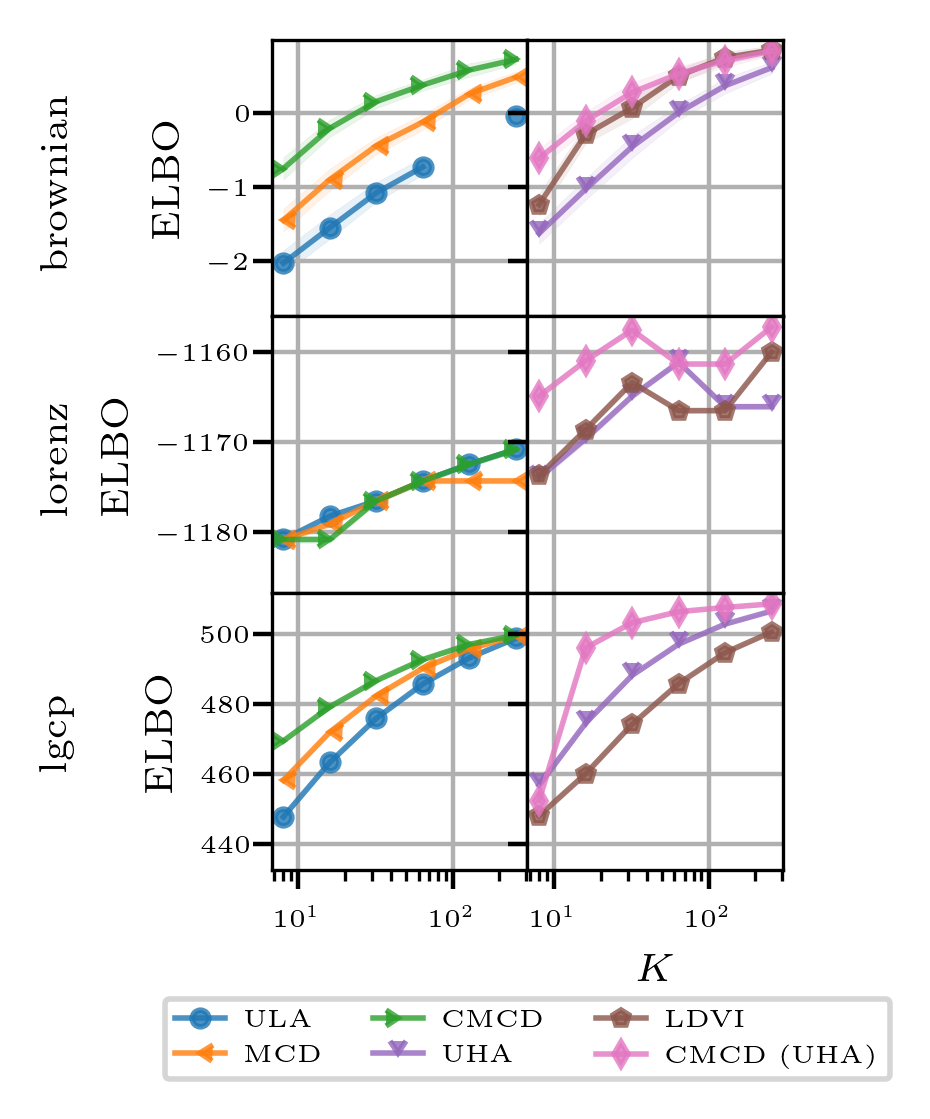

In [55]:
# Code for plotting

# Define the list of boundmodes and models to plot
from math import e
from re import A


boundmodes_to_plot_1st = ['MCD_ULA', 'MCD_ULA_sn', 'MCD_CAIS_sn']
boundmodes_to_plot_2nd = ['UHA', 'MCD_U_a-lp-sn', 'MCD_CAIS_UHA_sn']

models_to_plot = ['brownian', 'lorenz', 'lgcp']

# models_to_plot = ['log_sonar', 'log_ionosphere', 'seeds']

print(df[(df['boundmode'] == 'MCD_CAIS_UHA_sn') & (df['model'] == 'brownian')])

legend_names = {'MCD_ULA': 'ULA', 'MCD_ULA_sn': 'MCD', 'MCD_CAIS_sn': 'CMCD', 'UHA': 'UHA', 'MCD_U_a-lp-sn': 'LDVI', 'MCD_CAIS_UHA_sn': 'CMCD (UHA)', 'smc': 'SMC'}
# Create a subplot for each model
fig, axs = plt.subplots(len(models_to_plot), 2, figsize=(0.3 * text_width, 0.5 * text_width), dpi=400, sharey='row', sharex='col')

plt.subplots_adjust(wspace=0, hspace=0)
# Iterate over each model and plot the elbo_final values for each nbridges value
for i, model in enumerate(models_to_plot):
    all_elbos = []
    # Filter the df_new DataFrame to only include the given boundmodes and model
    
    for j, boundmode in enumerate(boundmodes_to_plot_1st):
        elbos, elbos_std = [], []
        for nbridge in sorted(unique_nbridges):
            df_filtered = df[(df['boundmode'] == boundmode) & (df['model'] == model) & (df['nbridges'] == nbridge)]
            print(boundmode, model, nbridge, df_filtered['elbo'].values)
            elbos.append(df_filtered['elbo'].values[-1])
            elbos_std.append(df_filtered['elbo_std'].values[-1])
            all_elbos.append(elbos[-1])
        # elbos = np.array([x[0] if isinstance(x, np.array) else x for x in elbos]).ravel()
        # elbos_std = np.array([x[0] if isinstance(x, np.array) else x for x in elbos_std]).ravel()
        elbos, elbos_std = np.squeeze(np.array(elbos)), np.squeeze(np.array(elbos_std))
        print(elbos.shape, elbos_std.shape)
        print(elbos, elbos_std)
        # axs[i].plot(sorted(unique_nbridges), elbos, color=c[j], marker=markerlist[j], label=legend_names[boundmode])
        errorfill(sorted(unique_nbridges), elbos, 2 * elbos_std, 
                  color=c[j], alpha_fill=0.1, line_alpha=0.8,
                  ax=axs[i][0], lw=1, linestyle='-', 
                  fill_linewidths=0.1, marker=markerlist[j], markersize=3, 
                  label=legend_names[boundmode])
    # axs[i].plot(df_filtered['nbridges'], df_filtered['elbo_final'], color=c[i], marker=markerlist[i])
    
    # Set the title and y-axis label for the subplot
    # axs[i][0].set_title(model)
    plt.figtext(-0.2, 0.25 + 0.25 * i, models_to_plot[-1 - i], rotation=90, va='center', ha='center')

    # if i == 0:
        # handles, labels = axs[0][-1].get_legend_handles_labels()
    # axs[0][0].legend(loc='lower center', ncol=3, bbox_to_anchor=(1, -1.5))
    axs[i][0].grid(0.3, zorder=0)
    if i == 2:
        axs[i][0].set_xticks([8, 32, 64, 128, 256])
    else:
        axs[i][0].set_xticklabels([])
        axs[i][0].set_xticks([])

    axs[i][0].set_ylabel(r'ELBO')
    
    for j, boundmode in enumerate(boundmodes_to_plot_2nd):

        # Plot the elbo_final values for each nbridges value
        elbos, elbos_std = [], []
        for nbridge in sorted(unique_nbridges):
            print(boundmode, model, nbridge)
            # Get the correct DF
            # print(df[(df['boundmode'] == boundmode) & (df['model'] == model) & (df['nbridges'] == nbridge)])
            df_filtered = df[(df['boundmode'] == boundmode) & (df['model'] == model) & (df['nbridges'] == nbridge)]
            print(boundmode, model, nbridge, df_filtered['elbo'].values)
            elbos.append(df_filtered['elbo'].values[-1])
            elbos_std.append(df_filtered['elbo_std'].values[-1])
            all_elbos.append(elbos[-1])
        # elbos_final = [x if np.isscalar(elbos) else x[0] for x in elbos]
        # elbos_std_final = [x if np.isscalar(elbos_std) else x[0] for x in elbos_std]
        elbos, elbos_std = np.squeeze(np.array(elbos)), np.squeeze(np.array(elbos_std))
        print(elbos, elbos_std)
        # axs[i].plot(sorted(unique_nbridges), elbos, color=c[j], marker=markerlist[j], label=legend_names[boundmode])
        errorfill(sorted(unique_nbridges), elbos, 2 * elbos_std, 
                  color=c[j+4], alpha_fill=0.1, line_alpha=0.8,
                  ax=axs[i][1], lw=1, linestyle='-', 
                  fill_linewidths=0.1, marker=markerlist[j+4], markersize=3, 
                  label=legend_names[boundmode])
        if i == 2:

            axs[i][1].set_xlabel(r'$K$')
    
    all_elbos = np.nan_to_num(np.array(all_elbos))
    global_min, global_max = np.min(all_elbos), np.max(all_elbos)
    
    axs[i][0].set_ylim(global_min - 0.25 * (global_max - global_min), global_max + 0.05 * (global_max - global_min))
    axs[i][1].set_ylim(global_min - 0.25 * (global_max - global_min), global_max + 0.05 * (global_max - global_min))
    # axs[i][0].set_yscale('log')


    if i == 2:
        axs[i][1].set_xticks([8, 32, 64, 128, 256])
    else:
        axs[i][1].set_xticklabels([])

    # axs[i].plot(df_filtered['nbridges'], df_filtered['elbo_final'], color=c[i], marker=markerlist[i])
    
    # Set the title and y-axis label for the subplot
    # axs[1][i].set_title(model)
    if i == 0:
        handles, labels = axs[1][-1].get_legend_handles_labels()
    # axs[1][0].legend(loc='lower center', ncol=3)
    axs[i][1].grid(0.3, zorder=0)
    axs[i][1].set_xticks([8, 32, 64, 128, 256])
    axs[i][0].tick_params(axis='y', which='major', pad=0)
    axs[i][1].tick_params(axis='y', which='major', pad=0)


    axs[i][0].set_xscale('log')
    axs[i][1].set_xscale('log')

h1, l1 = axs[0][0].get_legend_handles_labels()
h2, l2 = axs[0][1].get_legend_handles_labels()
axs[1][1].legend(h1+h2, l1+l2, loc='lower center', ncol=3, bbox_to_anchor=(0, -1.8))

# Set the x-axis label for the last subplot
# axs[-1].set_xlabel('nbridges')

# Show the plot
# plt.tight_layout()
plt.savefig('simple.pdf', bbox_inches='tight')
plt.show()




In [91]:
import wandb2numpy
import numpy as np

config = {
    "cais": {
        'entity': 'CAIS_benchmark',
        'project': 'CAIS_benchmark',
        'groups': ['smc'],
        'fields': [],
        'runs': ["all"],
        'config': {
            '_fields.num_temps': {
                'values': []
            },
        },
        'output_path': '',
    }}

alg = 'smc'
field = 'ELBO'
job_types = [
    'gmm_T',
    'lgcp_T',
    'lorenz_T',
    'banana_T',
    'brownian_T',
    'sonar_T',
    'ionosphere_T',
    'seeds_T',
    'funnel_T',
    'nice_T',
]
num_temps = [8, 16, 32, 64, 128, 256]
fields_arr = np.zeros([len(job_types), 26])

for j, num_temp in enumerate(num_temps):
    for i, sample_shape in enumerate(job_types):
        config['cais']['config']['_fields.num_temps']['values'] = [num_temp]
        config['cais']['job_types'] = [[job_types[i]]]
        config['cais']['fields'] = [field]
        config['cais']['groups'] = [alg]


        data_dict, config_list = wandb2numpy.export_data(config)
        fields_arr[i] = data_dict['cais'][field][:26].reshape(-1, )

    print(f'----------------K={num_temp}----------------')
    print(" \\\\\n".join(
            [f"& ${round(fields_arr.mean(1)[i], 3)} \pm {round(fields_arr.std(1)[i], 3)}$" for i in range(len(job_types))]))

No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
celestial-monkey-4982
olive-feather-4981
atomic-blaze-4980
wobbly-flower-4979
atomic-river-4978
cerulean-mountain-4977
rich-wind-4976
desert-water-4975
glamorous-oath-4974
genial-moon-4973
volcanic-plant-4972
hardy-microwave-4971
blooming-snowball-4970
avid-jazz-4969
glad-oath-4968
dulcet-grass-4967
polished-deluge-4966
prime-puddle-4965
young-water-4964
divine-energy-4963
driven-pine-4962
pretty-butterfly-4961
cosmic-star-4960
iconic-mountain-4959
smooth-tree-4958
trim-galaxy-4957
wandering-bee-4956
fresh-monkey-4955
ruby-oath-4954
fresh-totem-4953


100%|██████████| 30/30 [00:07<00:00,  3.94it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
kind-snowball-5162
genial-salad-5161
dazzling-sponge-5160
lunar-star-5159
winter-galaxy-5158
driven-silence-5157
happy-cherry-5156
trim-firebrand-5155
celestial-pine-5154
effortless-flower-5153
fresh-monkey-5152
dulcet-energy-5151
serene-hill-5150
skilled-wind-5149
stellar-blaze-5148
winter-darkness-5147
vocal-blaze-5146
absurd-fog-5145
eager-wood-5144
fallen-sun-5143
hearty-grass-5142
fine-plant-5141
efficient-forest-5140
copper-cherry-5139
stilted-lake-5138
faithful-bird-5137
drawn-vortex-5136
bright-gorge-5135
volcanic-wind-5134
youthful-surf-5133


100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
lively-dust-4082
whole-star-4081
fine-dew-4080
wobbly-yogurt-4079
celestial-sponge-4078
floral-cosmos-4077
stellar-snowflake-4076
toasty-music-4075
genial-smoke-4074
amber-valley-4073
amber-field-4072
elated-dew-4071
iconic-lion-4070
radiant-meadow-4069
fragrant-rain-4068
sunny-vortex-4067
clear-gorge-4066
icy-wood-4065
fanciful-bird-4064
smooth-firebrand-4063
glamorous-bird-4062
different-fire-4061
helpful-sea-4060
comic-dragon-4059
crimson-pyramid-4058
soft-river-4057
jumping-donkey-4056
dry-resonance-4055
spring-elevator-4054
misunderstood-sunset-4053


100%|██████████| 30/30 [00:07<00:00,  3.90it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
sunny-snow-3722
sage-donkey-3721
firm-terrain-3720
pretty-deluge-3719
iconic-wave-3718
clear-cherry-3717
ethereal-gorge-3716
whole-snowflake-3715
blooming-cloud-3714
summer-cosmos-3713
pious-star-3712
crimson-silence-3711
dry-eon-3710
unique-morning-3709
stilted-snowflake-3708
treasured-field-3707
classic-flower-3706
electric-planet-3705
easy-armadillo-3704
desert-pyramid-3703
sleek-armadillo-3702
pretty-valley-3701
elated-flower-3700
efficient-wave-3699
kind-butterfly-3698
leafy-tree-3697
pretty-fog-3696
vibrant-serenity-3695
young-brook-3694
clear-wood-3693


100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
dainty-violet-3902
tough-sea-3901
jumping-sound-3900
rich-plant-3899
drawn-firebrand-3898
robust-microwave-3897
still-meadow-3896
rich-wind-3895
balmy-firefly-3894
fragrant-pine-3893
glad-pond-3892
cool-disco-3891
ethereal-lake-3890
different-paper-3889
glad-feather-3888
dark-flower-3887
distinctive-paper-3886
robust-sunset-3885
eager-sun-3884
true-grass-3883
floral-wildflower-3882
devout-frost-3881
charmed-moon-3880
spring-pine-3879
breezy-feather-3878
valiant-puddle-3877
astral-yogurt-3876
fresh-disco-3875
stellar-darkness-3874
eager-durian-3873


100%|██████████| 30/30 [00:08<00:00,  3.57it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...


wandb: Network error (ConnectionError), entering retry loop.


Found following runs that match the filters:
bumbling-snow-4262
solar-dream-4261
good-dust-4260
daily-forest-4259
gallant-deluge-4258
pretty-firebrand-4257
proud-sponge-4256
winter-voice-4255
northern-capybara-4254
magic-donkey-4253
wandering-valley-4252
wandering-monkey-4251
effortless-elevator-4250
clear-star-4249
autumn-deluge-4248
jumping-shape-4247
mild-galaxy-4246
lyric-energy-4245
likely-mountain-4244
peach-bird-4243
curious-bird-4242
sandy-dew-4241
lemon-sun-4240
fancy-meadow-4239
glamorous-darkness-4238
true-salad-4237
wild-wildflower-4236
crisp-gorge-4235
cool-silence-4234
hearty-aardvark-4233


100%|██████████| 30/30 [00:08<00:00,  3.70it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
iconic-sea-4442
kind-leaf-4441
dandy-darkness-4440
avid-tree-4439
treasured-shadow-4438
noble-bee-4437
sage-energy-4436
zany-salad-4435
vague-plant-4434
earnest-cloud-4433
northern-feather-4432
neat-plant-4431
fanciful-oath-4430
fresh-blaze-4429
misunderstood-capybara-4428
visionary-sky-4427
fallen-salad-4426
neat-yogurt-4425
distinctive-gorge-4424
colorful-disco-4423
olive-grass-4422
classic-rain-4421
light-darkness-4420
dry-water-4419
daily-durian-4418
morning-morning-4417
absurd-galaxy-4416
unique-blaze-4415
earthy-river-4414
ethereal-wood-4413


100%|██████████| 30/30 [00:07<00:00,  3.90it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
vivid-smoke-4622
radiant-violet-4621
astral-valley-4620
charmed-silence-4619
honest-capybara-4618
cool-bee-4617
drawn-deluge-4616
worthy-snow-4615
good-tree-4614
stoic-hill-4613
balmy-butterfly-4612
solar-sea-4611
cerulean-deluge-4610
vivid-snowball-4609
laced-sponge-4608
winter-salad-4607
solar-eon-4606
lemon-firebrand-4605
playful-blaze-4604
woven-puddle-4603
effortless-sound-4602
expert-dust-4601
glamorous-glade-4600
atomic-sky-4599
mild-valley-4598
smart-rain-4597
visionary-feather-4596
floral-sun-4595
winter-universe-4594
zany-wildflower-4593


100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
clear-plant-4802
avid-wood-4801
brisk-resonance-4800
misunderstood-sound-4799
denim-glitter-4798
eager-meadow-4797
fresh-river-4796
fallen-music-4795
daily-wood-4794
bright-serenity-4793
youthful-sky-4792
efficient-gorge-4791
peach-water-4790
crisp-wave-4789
earthy-pine-4788
celestial-firebrand-4787
smart-armadillo-4786
light-oath-4785
desert-smoke-4784
logical-voice-4783
curious-microwave-4782
pleasant-voice-4781
dutiful-snowflake-4780
vibrant-monkey-4779
dandy-dust-4778
bumbling-fire-4777
atomic-field-4776
spring-disco-4775
vibrant-lion-4774
mild-sky-4773


100%|██████████| 30/30 [00:08<00:00,  3.55it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
wise-dragon-5342
sleek-meadow-5341
efficient-bush-5340
glowing-durian-5339
colorful-armadillo-5338
scarlet-wildflower-5337
likely-thunder-5336
dashing-fog-5335
fallen-serenity-5334
neat-flower-5333
smooth-yogurt-5332
desert-energy-5331
frosty-totem-5330
firm-cosmos-5329
hopeful-capybara-5328
gallant-fire-5327
devoted-plasma-5326
rose-serenity-5325
comfy-butterfly-5324
pious-pyramid-5323
honest-plasma-5322
visionary-firebrand-5321
dashing-valley-5320
electric-pyramid-5319
logical-sea-5318
soft-sea-5317
rose-wildflower-5316
fancy-elevator-5315
hearty-night-5314
radiant-fog-5313


100%|██████████| 30/30 [00:06<00:00,  4.39it/s]


Number of runs that include field ELBO: 30
----------------K=8----------------
& $-0.536 \pm 0.042$ \\
& $-364.074 \pm 7.797$ \\
& $-87502.352 \pm 4004.495$ \\
& $-1.767 \pm 0.283$ \\
& $-63.32 \pm 8.016$ \\
& $-178.589 \pm 2.784$ \\
& $-204.594 \pm 3.049$ \\
& $-108.676 \pm 1.221$ \\
& $-1.013 \pm 0.116$ \\
& $-269.417 \pm 7.614$
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
silvery-shadow-5012
denim-firebrand-5011
prime-silence-5010
expert-monkey-5009
lively-waterfall-5008
worldly-glade-5007
unique-wood-5006
vivid-river-5005
iconic-flower-5004
morning-darkness-5003
astral-gorge-5002
restful-breeze-5001
rich-spaceship-5000
fluent-frog-4999
likely-wind-4998
confused-thunder-4997
young-plasma-4996
visionary-mountain-4995
earthy-eon-4994
young-monkey-4993
firm-paper-4992
true-dragon-4991
dashing-sun-4990
graceful-thunder-4989
snowy-plasma-4988
swept-bush-4987
sunny-fire-4986
devoted-dragon-4985
celestial-wind-4984
faithful-wa

100%|██████████| 30/30 [00:06<00:00,  4.55it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
leafy-glade-5192
polar-water-5191
charmed-terrain-5190
atomic-valley-5189
stilted-feather-5188
major-firefly-5187
cerulean-feather-5186
still-valley-5185
noble-grass-5184
silvery-rain-5183
deep-night-5182
genial-planet-5181
crisp-puddle-5180
breezy-tree-5179
fluent-elevator-5178
pious-flower-5177
sandy-sky-5176
youthful-tree-5175
genial-vortex-5174
gentle-dust-5173
smooth-frost-5172
splendid-tree-5171
devoted-paper-5170
amber-frost-5169
stilted-universe-5168
noble-violet-5167
ancient-darkness-5166
earthy-plant-5165
decent-grass-5164
clean-rain-5163


100%|██████████| 30/30 [00:08<00:00,  3.57it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
iconic-energy-4112
azure-pond-4111
splendid-terrain-4110
fresh-bush-4109
bumbling-cloud-4108
gallant-serenity-4107
glowing-water-4106
whole-silence-4105
olive-snowball-4104
serene-shadow-4103
peach-snow-4102
robust-hill-4101
electric-sound-4100
exalted-river-4099
decent-donkey-4098
azure-darkness-4097
fine-puddle-4096
fine-fire-4095
noble-sun-4094
celestial-shape-4093
earthy-firefly-4092
ruby-mountain-4091
dulcet-snow-4090
lyric-bee-4089
dry-snowball-4088
generous-cosmos-4087
colorful-bird-4086
comic-surf-4085
fanciful-gorge-4084
decent-gorge-4083


100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
atomic-snowflake-3752
dandy-jazz-3751
icy-tree-3750
hardy-frog-3749
young-dawn-3748
dazzling-snowflake-3747
cosmic-energy-3746
lyric-water-3745
revived-jazz-3744
wobbly-wave-3743
dark-puddle-3742
robust-sound-3741
sage-pyramid-3740
robust-water-3739
woven-sky-3738
dainty-shape-3737
neat-galaxy-3736
sage-spaceship-3735
fresh-haze-3734
charmed-voice-3733
hardy-shape-3732
iconic-capybara-3731
pious-valley-3730
vocal-disco-3729
spring-waterfall-3728
pleasant-violet-3727
dainty-smoke-3726
rare-leaf-3725
vibrant-snow-3724
deep-deluge-3723


100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
fine-pond-3932
serene-voice-3931
swift-wildflower-3930
leafy-microwave-3929
peachy-surf-3928
woven-galaxy-3927
smooth-forest-3926
brisk-river-3925
pretty-haze-3924
robust-surf-3923
flowing-thunder-3922
dazzling-tree-3921
absurd-lake-3920
bright-sun-3919
firm-bird-3918
young-water-3917
whole-capybara-3916
robust-brook-3915
toasty-dew-3914
fine-brook-3913
classic-elevator-3912
comic-armadillo-3911
fiery-night-3910
logical-leaf-3909
dark-lion-3908
dashing-bee-3907
major-water-3906
curious-fog-3905
treasured-snowball-3904
bright-frost-3903


100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
playful-sky-4292
crimson-deluge-4291
jolly-aardvark-4290
playful-durian-4289
confused-wind-4288
treasured-lake-4287
colorful-vortex-4286
worldly-snow-4285
misunderstood-monkey-4284
clean-sound-4283
dandy-jazz-4282
devoted-sponge-4281
lyric-fog-4280
crisp-leaf-4279
honest-mountain-4278
scarlet-night-4277
bright-firebrand-4276
olive-armadillo-4275
pious-deluge-4274
true-microwave-4273
electric-haze-4272
proud-meadow-4271
dazzling-voice-4270
worthy-flower-4269
deep-tree-4268
blooming-salad-4267
lilac-sun-4266
magic-capybara-4265
breezy-frog-4264
tough-tree-4263


100%|██████████| 30/30 [00:08<00:00,  3.49it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
cerulean-waterfall-4472
woven-capybara-4471
flowing-water-4470
royal-sponge-4469
desert-shape-4468
revived-mountain-4467
hearty-salad-4466
firm-breeze-4465
rural-river-4464
graceful-smoke-4463
vague-eon-4462
wobbly-puddle-4461
gentle-sun-4460
cool-snowflake-4459
frosty-morning-4458
dauntless-valley-4457
vocal-salad-4456
pretty-river-4455
dulcet-snow-4454
stoic-snowflake-4453
elated-lake-4452
sandy-sky-4451
giddy-flower-4450
still-jazz-4449
snowy-galaxy-4448
cerulean-valley-4447
dainty-mountain-4446
solar-sunset-4445
worthy-capybara-4444
avid-hill-4443


100%|██████████| 30/30 [00:07<00:00,  3.92it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
breezy-snow-4652
sunny-breeze-4651
devout-night-4650
elated-capybara-4649
devout-sponge-4648
noble-dawn-4647
jumping-wind-4646
sweet-microwave-4645
robust-feather-4644
rare-energy-4643
fresh-cloud-4642
helpful-cosmos-4641
unique-armadillo-4640
jolly-voice-4639
dutiful-universe-4638
rural-river-4637
cool-salad-4636
dazzling-breeze-4635
eager-lake-4634
faithful-fog-4633
skilled-pyramid-4632
sage-lake-4631
major-river-4630
wild-morning-4629
wobbly-sea-4628
lunar-yogurt-4627
breezy-dust-4626
scarlet-dawn-4625
tough-grass-4624
elated-bee-4623


100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
vocal-pyramid-4832
bright-aardvark-4831
earnest-sound-4830
pious-river-4829
zesty-night-4828
mild-eon-4827
magic-deluge-4826
legendary-valley-4825
radiant-firefly-4824
helpful-glitter-4823
earthy-puddle-4822
summer-water-4821
charmed-dragon-4820
floral-breeze-4819
sunny-darkness-4818
lively-sun-4817
royal-cherry-4816
efficient-capybara-4815
glamorous-dragon-4814
atomic-moon-4813
dashing-fog-4812
bright-silence-4811
curious-donkey-4810
crisp-wildflower-4809
stilted-aardvark-4808
generous-snowball-4807
clear-monkey-4806
dark-disco-4805
lively-snowflake-4804
distinctive-wildflower-4803


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
decent-sound-5372
spring-salad-5371
skilled-sunset-5370
polar-microwave-5369
comic-sun-5368
super-monkey-5367
pious-durian-5366
dandy-valley-5365
firm-terrain-5364
silvery-resonance-5363
ancient-rain-5362
colorful-elevator-5361
skilled-morning-5360
azure-dragon-5359
likely-feather-5358
winter-eon-5357
glowing-eon-5356
fallen-rain-5355
super-pine-5354
zesty-wave-5353
neat-surf-5352
sparkling-galaxy-5351
chocolate-dawn-5350
proud-armadillo-5349
clear-voice-5348
honest-haze-5347
dry-surf-5346
bumbling-capybara-5345
peachy-snow-5344
colorful-pond-5343


100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


Number of runs that include field ELBO: 30
----------------K=16----------------
& $-0.255 \pm 0.034$ \\
& $-135.207 \pm 4.665$ \\
& $-42148.287 \pm 1047.478$ \\
& $-1.256 \pm 0.265$ \\
& $-28.714 \pm 3.71$ \\
& $-137.691 \pm 1.656$ \\
& $-149.107 \pm 1.088$ \\
& $-88.068 \pm 0.467$ \\
& $-0.65 \pm 0.1$ \\
& $-103.667 \pm 2.385$
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
floral-sunset-5042
honest-grass-5041
resilient-leaf-5040
youthful-brook-5039
frosty-salad-5038
dashing-lake-5037
elated-snow-5036
vital-fog-5035
drawn-plasma-5034
stellar-field-5033
super-resonance-5032
sandy-fog-5031
devout-jazz-5030
dry-capybara-5029
sandy-thunder-5028
dandy-firebrand-5027
denim-rain-5026
young-forest-5025
rare-galaxy-5024
leafy-dust-5023
polished-frog-5022
blooming-sound-5021
crimson-wind-5020
elated-valley-5019
dandy-salad-5018
devoted-plant-5017
silvery-wind-5016
graceful-pond-5015
clean-durian-5014
ruby-night-5013


100%|██████████| 30/30 [00:07<00:00,  3.80it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
treasured-wave-5222
iconic-voice-5221
sleek-salad-5220
vibrant-darkness-5219
glad-firefly-5218
fine-yogurt-5217
giddy-capybara-5216
cosmic-grass-5215
wandering-wave-5214
stilted-fog-5213
fresh-smoke-5212
still-flower-5211
cosmic-pyramid-5210
scarlet-snowball-5209
hardy-surf-5208
still-tree-5207
golden-cosmos-5206
crimson-lake-5205
polar-puddle-5204
gallant-cherry-5203
classic-surf-5202
dulcet-universe-5201
treasured-music-5200
elated-morning-5199
earthy-voice-5198
cool-gorge-5197
eager-grass-5196
dulcet-firefly-5195
avid-capybara-5194
usual-smoke-5193


100%|██████████| 30/30 [00:08<00:00,  3.46it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
restful-dragon-4142
wild-fire-4141
desert-violet-4140
comic-bee-4139
comfy-star-4138
electric-star-4137
dandy-flower-4136
soft-music-4135
cosmic-pyramid-4134
trim-pond-4133
fresh-wind-4132
valiant-shape-4131
silver-mountain-4130
brisk-mountain-4129
happy-capybara-4128
neat-butterfly-4127
azure-salad-4126
sparkling-wave-4125
glad-valley-4124
fragrant-bird-4123
kind-river-4122
wild-surf-4121
honest-elevator-4120
devoted-fog-4119
honest-hill-4118
major-mountain-4117
dark-serenity-4116
cerulean-bee-4115
golden-butterfly-4114
mild-plasma-4113


100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
sleek-forest-3782
cool-flower-3781
chocolate-glade-3780
bright-forest-3779
lively-rain-3778
still-grass-3777
rich-dawn-3776
golden-silence-3775
stoic-vortex-3774
iconic-water-3773
cosmic-morning-3772
glamorous-pine-3771
decent-forest-3770
comfy-haze-3769
stellar-totem-3768
dulcet-rain-3767
clean-feather-3766
firm-surf-3765
fluent-bee-3764
likely-tree-3763
dandy-puddle-3762
woven-cosmos-3761
fancy-sun-3760
proud-waterfall-3759
skilled-hill-3758
zesty-bee-3757
restful-bee-3756
lively-snowflake-3755
major-deluge-3754
legendary-feather-3753


100%|██████████| 30/30 [00:07<00:00,  3.78it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
hardy-pyramid-3962
morning-sun-3961
iconic-lake-3960
cerulean-dream-3959
restful-music-3958
curious-cloud-3957
faithful-bird-3956
flowing-glade-3955
woven-pyramid-3954
atomic-dream-3953
different-elevator-3952
colorful-galaxy-3951
vague-sponge-3950
crimson-bird-3949
still-plasma-3948
lyric-silence-3947
resilient-shape-3946
crimson-pond-3945
leafy-oath-3944
snowy-meadow-3943
eager-pine-3942
cosmic-elevator-3941
major-puddle-3940
spring-shadow-3939
rich-field-3938
playful-universe-3937
fresh-firefly-3936
sage-salad-3935
deep-dawn-3934
youthful-shape-3933


100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
fancy-deluge-4322
confused-flower-4321
rare-forest-4320
jumping-energy-4319
major-shadow-4318
vibrant-sponge-4317
confused-waterfall-4316
copper-lake-4315
helpful-lake-4314
denim-dawn-4313
distinctive-breeze-4312
usual-darkness-4311
drawn-river-4310
silvery-field-4309
warm-galaxy-4308
frosty-star-4307
sleek-dust-4306
fragrant-wave-4305
crisp-pyramid-4304
ethereal-star-4303
smart-gorge-4302
confused-snow-4301
fallen-pine-4300
lively-salad-4299
fiery-capybara-4298
blooming-bee-4297
proud-dew-4296
woven-aardvark-4295
copper-paper-4294
drawn-wood-4293


100%|██████████| 30/30 [00:08<00:00,  3.64it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
morning-deluge-4502
absurd-totem-4501
flowing-flower-4500
comfy-sunset-4499
skilled-energy-4498
scarlet-flower-4497
giddy-oath-4496
driven-firefly-4495
mild-wildflower-4494
smooth-shape-4493
driven-vortex-4492
sandy-totem-4491
woven-breeze-4490
comic-tree-4489
glowing-moon-4488
zany-totem-4487
fearless-sound-4486
zany-yogurt-4485
splendid-disco-4484
toasty-sponge-4483
elated-cosmos-4482
dutiful-spaceship-4481
deep-vortex-4480
northern-pine-4479
soft-jazz-4478
devout-frost-4477
drawn-tree-4476
eager-pine-4475
breezy-water-4474
rural-salad-4473


100%|██████████| 30/30 [00:07<00:00,  4.13it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
daily-violet-4682
worldly-voice-4681
grateful-bee-4680
kind-butterfly-4679
usual-water-4678
restful-field-4677
deep-dream-4676
classic-disco-4675
exalted-tree-4674
fine-cosmos-4673
iconic-lake-4672
young-river-4671
helpful-blaze-4670
visionary-planet-4669
eager-armadillo-4668
pretty-sun-4667
good-morning-4666
hopeful-shape-4665
glowing-snow-4664
dauntless-plant-4663
solar-vortex-4662
confused-bird-4661
efficient-glitter-4660
dashing-jazz-4659
valiant-firefly-4658
apricot-resonance-4657
amber-star-4656
classic-frost-4655
wild-silence-4654
wise-feather-4653


100%|██████████| 30/30 [00:07<00:00,  3.83it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
whole-fog-4862
rosy-voice-4861
worthy-snow-4860
decent-pyramid-4859
spring-leaf-4858
super-lake-4857
gallant-spaceship-4856
apricot-butterfly-4855
glowing-frost-4854
ruby-oath-4853
wise-forest-4852
desert-sponge-4851
radiant-capybara-4850
fluent-pond-4849
firm-music-4848
noble-dream-4847
upbeat-cosmos-4846
astral-dream-4845
ancient-glade-4844
magic-serenity-4843
autumn-puddle-4842
fragrant-bee-4841
peach-feather-4840
dashing-elevator-4839
good-wave-4838
silver-wood-4837
swift-river-4836
decent-tree-4835
daily-wave-4834
distinctive-smoke-4833


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
fancy-cloud-5402
soft-music-5401
icy-mountain-5400
feasible-dew-5399
fallen-microwave-5398
frosty-tree-5397
easy-bird-5396
neat-oath-5395
electric-pyramid-5394
divine-pond-5393
lunar-sunset-5392
rural-brook-5391
vague-fog-5390
misunderstood-bush-5389
summer-darkness-5388
smart-haze-5387
celestial-totem-5386
blooming-firefly-5385
devoted-music-5384
wobbly-rain-5383
playful-wood-5382
effortless-night-5381
revived-pond-5380
wobbly-donkey-5379
major-wave-5378
scarlet-sunset-5377
resilient-aardvark-5376
decent-planet-5375
bumbling-wood-5374
pretty-feather-5373


100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


Number of runs that include field ELBO: 30
----------------K=32----------------
& $-0.119 \pm 0.017$ \\
& $86.106 \pm 5.989$ \\
& $-19288.267 \pm 834.52$ \\
& $-0.752 \pm 0.447$ \\
& $-12.23 \pm 2.212$ \\
& $-120.557 \pm 0.613$ \\
& $-127.964 \pm 0.394$ \\
& $-79.89 \pm 0.273$ \\
& $-0.408 \pm 0.17$ \\
& $-45.252 \pm 1.942$
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
polished-plant-5072
vocal-frog-5071
ethereal-paper-5070
graceful-gorge-5069
exalted-resonance-5068
misunderstood-brook-5067
rosy-wave-5066
robust-glitter-5065
eternal-snowflake-5064
grateful-pine-5063
deft-tree-5062
celestial-breeze-5061
comic-blaze-5060
tough-meadow-5059
solar-dragon-5058
youthful-darkness-5057
grateful-bush-5056
light-haze-5055
eternal-dragon-5054
gallant-salad-5053
deep-feather-5052
effortless-morning-5051
firm-dust-5050
legendary-durian-5049
peach-aardvark-5048
skilled-valley-5047
eternal-dawn-5046
eager-rain-5045
drawn-salad-5044
absurd-

100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
rural-water-5252
blooming-serenity-5251
pretty-firefly-5250
winter-bird-5249
revived-donkey-5248
amber-lake-5247
rosy-terrain-5246
sage-shape-5245
fancy-violet-5244
floral-wildflower-5243
laced-surf-5242
fluent-thunder-5241
vocal-plasma-5240
glamorous-microwave-5239
cerulean-haze-5238
fancy-armadillo-5237
glowing-dawn-5236
sparkling-aardvark-5235
daily-wood-5234
crisp-sea-5233
vague-pond-5232
apricot-vortex-5231
divine-glade-5230
fanciful-tree-5229
sparkling-vortex-5228
zesty-donkey-5227
drawn-brook-5226
solar-vortex-5225
daily-sponge-5224
sparkling-deluge-5223


100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
exalted-sun-4172
clear-mountain-4171
cool-galaxy-4170
gallant-silence-4169
clear-wood-4168
wandering-rain-4167
fine-shadow-4166
copper-paper-4165
genial-feather-4164
light-darkness-4163
expert-sky-4162
classic-silence-4161
dainty-hill-4160
lilac-snowflake-4159
dainty-resonance-4158
prime-monkey-4157
legendary-bush-4156
jumping-serenity-4155
ruby-salad-4154
magic-disco-4153
polar-wave-4152
trim-terrain-4151
denim-disco-4150
misunderstood-firefly-4149
chocolate-hill-4148
lemon-monkey-4147
genial-sun-4146
lucky-mountain-4145
kind-smoke-4144
still-lake-4143


100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
hopeful-bee-3812
restful-cloud-3811
glamorous-river-3810
stoic-leaf-3809
lyric-glitter-3808
warm-aardvark-3807
dulcet-donkey-3806
flowing-darkness-3805
golden-dream-3804
misunderstood-dream-3803
cerulean-deluge-3802
azure-moon-3801
dainty-salad-3800
zesty-sound-3799
chocolate-silence-3798
misunderstood-breeze-3797
smooth-river-3796
balmy-darkness-3795
brisk-armadillo-3794
serene-flower-3793
clear-star-3792
fallen-donkey-3791
solar-sea-3790
laced-wave-3789
clean-planet-3788
fluent-firefly-3787
dulcet-star-3786
frosty-galaxy-3785
cerulean-salad-3784
genial-cherry-3783


100%|██████████| 30/30 [00:07<00:00,  3.87it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
swept-sea-3992
upbeat-tree-3991
pretty-totem-3990
woven-puddle-3989
absurd-sun-3988
graceful-cherry-3987
solar-bird-3986
fiery-vortex-3985
morning-violet-3984
fragrant-sun-3983
wise-oath-3982
helpful-microwave-3981
graceful-wave-3980
treasured-water-3979
worthy-bush-3978
restful-galaxy-3977
woven-vortex-3976
eternal-frog-3975
rare-haze-3974
avid-cherry-3973
pleasant-breeze-3972
devout-meadow-3971
expert-meadow-3970
polar-morning-3969
smart-hill-3968
upbeat-haze-3967
atomic-eon-3966
dauntless-dream-3965
solar-disco-3964
glorious-puddle-3963


100%|██████████| 30/30 [00:06<00:00,  4.35it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
fanciful-gorge-4352
lucky-oath-4351
upbeat-surf-4350
peachy-dream-4349
scarlet-pond-4348
sleek-mountain-4347
dandy-gorge-4346
dandy-elevator-4345
fearless-resonance-4344
absurd-wildflower-4343
bumbling-yogurt-4342
chocolate-dragon-4341
balmy-planet-4340
smart-mountain-4339
deep-lake-4338
proud-wind-4337
logical-sound-4336
twilight-dawn-4335
leafy-bush-4334
distinctive-terrain-4333
logical-donkey-4332
zany-music-4331
desert-plasma-4330
dashing-aardvark-4329
amber-disco-4328
daily-lion-4327
eager-jazz-4326
stilted-rain-4325
feasible-sky-4324
revived-terrain-4323


100%|██████████| 30/30 [00:08<00:00,  3.59it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
volcanic-bush-4532
iconic-pond-4531
usual-fog-4530
effortless-aardvark-4529
vital-tree-4528
earnest-moon-4527
wild-sea-4526
stellar-sound-4525
olive-cherry-4524
ethereal-deluge-4523
glad-sponge-4522
solar-dragon-4521
feasible-bush-4520
crisp-haze-4519
balmy-butterfly-4518
stilted-microwave-4517
worthy-galaxy-4516
bright-bush-4515
stilted-eon-4514
wise-fire-4513
apricot-music-4512
leafy-salad-4511
leafy-sun-4510
sage-pine-4509
logical-mountain-4508
toasty-wildflower-4507
fearless-surf-4506
swept-vortex-4505
driven-aardvark-4504
dark-deluge-4503


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
decent-shape-4712
valiant-cherry-4711
mild-glade-4710
smart-dream-4709
faithful-dawn-4708
sweet-salad-4707
crisp-rain-4706
wandering-paper-4705
young-puddle-4704
faithful-capybara-4703
pretty-shape-4702
exalted-yogurt-4701
cool-violet-4700
sandy-water-4699
lyric-sound-4698
serene-capybara-4697
crimson-star-4696
resilient-voice-4695
lyric-field-4694
glowing-pond-4693
generous-dew-4692
efficient-sound-4691
stellar-breeze-4690
flowing-bee-4689
cool-meadow-4688
kind-silence-4687
ethereal-lion-4686
feasible-flower-4685
tough-wood-4684
major-tree-4683


100%|██████████| 30/30 [00:08<00:00,  3.42it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
fresh-microwave-4892
ancient-firebrand-4891
fanciful-cloud-4890
tough-firefly-4889
vital-sea-4888
hardy-breeze-4887
dandy-firebrand-4886
peachy-sun-4885
true-elevator-4884
splendid-eon-4883
vague-gorge-4882
jolly-music-4881
dry-sea-4880
balmy-voice-4879
neat-wave-4878
flowing-leaf-4877
legendary-wind-4876
noble-salad-4875
iconic-sun-4874
true-deluge-4873
laced-sea-4872
swift-wind-4871
playful-rain-4870
splendid-leaf-4869
confused-resonance-4868
cool-sun-4867
visionary-flower-4866
firm-lion-4865
hardy-pine-4864
decent-yogurt-4863


100%|██████████| 30/30 [00:09<00:00,  3.32it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
stellar-firebrand-5432
sweet-leaf-5431
wise-silence-5430
magic-field-5429
twilight-dust-5428
dark-voice-5427
woven-smoke-5426
cerulean-music-5425
likely-terrain-5424
polished-moon-5423
sandy-resonance-5422
tough-glitter-5421
fiery-silence-5420
fresh-wood-5419
dry-salad-5418
dark-durian-5417
breezy-music-5416
toasty-forest-5415
laced-snowflake-5414
hardy-fire-5413
trim-butterfly-5412
volcanic-snow-5411
effortless-dawn-5410
clear-cloud-5409
silver-sunset-5408
dark-sun-5407
major-surf-5406
glad-puddle-5405
sandy-armadillo-5404
vital-valley-5403


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Number of runs that include field ELBO: 30
----------------K=64----------------
& $-0.059 \pm 0.015$ \\
& $269.566 \pm 7.832$ \\
& $-8894.525 \pm 119.723$ \\
& $-0.69 \pm 0.242$ \\
& $-4.76 \pm 1.042$ \\
& $-113.835 \pm 0.167$ \\
& $-118.812 \pm 0.192$ \\
& $-76.275 \pm 0.189$ \\
& $-0.359 \pm 0.087$ \\
& $-21.244 \pm 1.203$
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
valiant-planet-5102
soft-tree-5101
happy-resonance-5100
pious-darkness-5099
apricot-donkey-5098
quiet-glade-5097
misty-spaceship-5096
woven-totem-5095
twilight-universe-5094
vague-terrain-5093
usual-bush-5092
astral-sun-5091
royal-spaceship-5090
curious-glade-5089
woven-feather-5088
eternal-gorge-5087
silver-violet-5086
worldly-elevator-5085
visionary-breeze-5084
wild-water-5083
laced-energy-5082
avid-durian-5081
easy-vortex-5080
youthful-elevator-5079
helpful-rain-5078
sunny-violet-5077
vital-eon-5076
desert-moon-5075
smooth-sponge-5074
silver-water-5073


100%|██████████| 30/30 [00:09<00:00,  3.32it/s]


Number of runs that include field ELBO: 30
No DEFAULT entry found in config
Processing experiment cais ...
Found following runs that match the filters:
resilient-snowball-5282
worthy-armadillo-5281
true-pyramid-5280
serene-snow-5279
efficient-terrain-5278
volcanic-wind-5277
stilted-surf-5276
jumping-water-5275
gentle-silence-5274
happy-glitter-5273
dashing-water-5272
deep-moon-5271
pleasant-cherry-5270
decent-dream-5269
vague-leaf-5268
hopeful-totem-5267
charmed-thunder-5266
lemon-moon-5265
autumn-field-5264
giddy-firebrand-5263
hopeful-elevator-5262
lemon-music-5261
worldly-snowflake-5260
ancient-dawn-5259
fancy-cosmos-5258
dandy-shape-5257
quiet-galaxy-5256
magic-sun-5255
zany-waterfall-5254
astral-music-5253


 27%|██▋       | 8/30 [00:02<00:08,  2.72it/s]


KeyboardInterrupt: 

In [58]:
# Data provided
data = {
    "gmm": ["-3.588+-0.17", "-1.258+-0.095", "-0.568+-0.068", "-0.255+-0.051", "-0.13+-0.023", "-0.064+-0.016"],
    "lgcp": ["-908.515+-0.98", "-550.369+-2.217", "-238.383+-5.282", "24.515+-4.26", "227.668+-3.58", "363.193+-2.581"],
    "lorenz": ["-424.3K+-4.20K", "-161.0K+-3.77K", "-71.4K+-2.71K", "-34.7K+-1.12K", "-16.1K+-0.50K", "-8.09K+-0.07K"],
    "banana": ["-6.234+-0.109", "-2.866+-0.373", "-1.677+-0.23", "-1.054_(+-0.304)", "-0.772+-0.327", "-0.559+-0.211"],
    "brownian": ["-358.901+-61.354", "-129.755+-20.462", "-53.052+-8.88", "-23.297+-4.082", "-10.203+-1.903", "-4.227+-1.034"],
    "log_sonar": ["-643.777+-8.964", "-284.659_(+-8.689)", "-175.351_(+-1.705)", "-137.242_(+-1.187)", "-120.792+-0.999", "-114.496+-0.468"],
    "log_ionosphere": ["-799.015+-13.291", "-342.812+-6.767", "-201.717+-2.5", "-149.307+-1.166", "-128.077+-0.519", "-118.814+-0.279"],
    "seeds": ["-347.002+-8.511", "-159.944_(+-2.956)", "-107.768+-1.465", "-88.024+-0.675", "-79.869_(+-0.428)", "-76.26+-0.262"],
    "funnel": ["-3.711_(+-0.406)", "-1.693+-0.177", "-1.018+-0.113", "-0.616+-0.117", "-0.425+-0.091", "-0.303+-0.086"],
    "nice": ["-1830.042_(+-6.694)", "-556.984+-4.626", "-213.82+-2.902", "-90.183+-1.645", "-41.023+-1.112", "-19.541+-0.824"]
}

# Bridges
bridges = [8, 16, 32, 64, 128, 256]

# Helper function to extract mean and std from data
def extract_values(s):
    s = s.replace("K", "000").replace("_(", "").replace(")", "").replace("+-", "+- ").split("+-")
    mean = float(s[0])
    std = float(s[1])
    return mean, std

# Constructing the dictionary
result = {}
for model, values in data.items():
    result[model] = {}
    for i, val in enumerate(values):
        mean, std = extract_values(val)
        result[model][bridges[i]] = {'mean': mean, 'std': std}

print(result)

{'gmm': {8: {'mean': -3.588, 'std': 0.17}, 16: {'mean': -1.258, 'std': 0.095}, 32: {'mean': -0.568, 'std': 0.068}, 64: {'mean': -0.255, 'std': 0.051}, 128: {'mean': -0.13, 'std': 0.023}, 256: {'mean': -0.064, 'std': 0.016}}, 'lgcp': {8: {'mean': -908.515, 'std': 0.98}, 16: {'mean': -550.369, 'std': 2.217}, 32: {'mean': -238.383, 'std': 5.282}, 64: {'mean': 24.515, 'std': 4.26}, 128: {'mean': 227.668, 'std': 3.58}, 256: {'mean': 363.193, 'std': 2.581}}, 'lorenz': {8: {'mean': -424.3, 'std': 4.2}, 16: {'mean': -161.0, 'std': 3.77}, 32: {'mean': -71.4, 'std': 2.71}, 64: {'mean': -34.7, 'std': 1.12}, 128: {'mean': -16.1, 'std': 0.5}, 256: {'mean': -8.09, 'std': 0.07}}, 'banana': {8: {'mean': -6.234, 'std': 0.109}, 16: {'mean': -2.866, 'std': 0.373}, 32: {'mean': -1.677, 'std': 0.23}, 64: {'mean': -1.054, 'std': 0.304}, 128: {'mean': -0.772, 'std': 0.327}, 256: {'mean': -0.559, 'std': 0.211}}, 'brownian': {8: {'mean': -358.901, 'std': 61.354}, 16: {'mean': -129.755, 'std': 20.462}, 32: {'me

In [87]:
# Define the data
models = ["gmm", "lgcp", "lorenz", "banana", "brownian", "log_sonar", "log_ionosphere", "seeds", "funnel"]
bridges = [8, 16, 32, 64, 128, 256]
values = [
    [-0.536, -364.074, 87502.352, -1.767, -63.32, -178.589, -204.594, -108.676, -1.013],
    [-0.255, -135.207, 42148.287, -1.256, -28.714, -137.691, -149.107, -88.068, -0.65],
    [-0.119, 86.106, -19288.267, -0.752, -12.23, -120.557, -127.964, -79.89, -0.408],
    [-0.059, 269.566, -8894.525, -0.69, -4.76, -113.835, -118.812, -76.275, -0.359],
    [-0.029, 390.33, -5419.678, -0.437, -1.675, -110.901, -114.827, -74.774, -0.255],
    [-0.013, 453.395, -3745.218, -0.284, -0.131, -109.562, -113.123, -74.049, -0.211]
]
std_devs = [
    [0.042, 7.797, 4004.495, 0.283, 8.016, 2.784, 3.049, 1.221, 0.116],
    [0.034, 4.665, 1047.478, 0.265, 3.71, 1.656, 1.088, 0.467, 0.1],
    [0.017, 5.989, 834.52, 0.447, 2.212, 0.613, 0.394, 0.273, 0.17],
    [0.015, 7.832, 119.723, 0.242, 1.042, 0.167, 0, 0.189, 0.087],
    [0.009, 5.427, 90.362, 0.37, 0.442, 0.094, 0.307, 0.097, 0.108],
    [0.006, 4.43, 68.342, 0.295, 0.22, 0.072, 0.172, 0.088, 0.074]
]

# Create the dictionary
data_dict = {}
for model in models:
    data_dict[model] = {}
    for bridge, value, std_dev in zip(bridges, values, std_devs):
        data_dict[model][bridge] = {
            "mean": value[models.index(model)],
            "std": std_dev[models.index(model)]
        }

data_dict

result = data_dict

MCD_ULA brownian [-2.0328269]
MCD_ULA brownian [-1.55235052]
MCD_ULA brownian [-1.08183038]
MCD_ULA brownian [-0.73099136]
MCD_ULA brownian [nan]
MCD_ULA brownian [-0.04644253]
(6,) (6,)
[-2.0328269  -1.55235052 -1.08183038 -0.73099136         nan -0.04644253] [0.08059385 0.08199829 0.06675862 0.05752162        nan 0.04606363]
MCD_ULA_sn brownian [-1.45294023]
MCD_ULA_sn brownian [-0.90202922]
MCD_ULA_sn brownian [-0.44545698]
MCD_ULA_sn brownian [-0.12460797]
MCD_ULA_sn brownian [0.25486571]
MCD_ULA_sn brownian [0.48158082]
(6,) (6,)
[-1.45294023 -0.90202922 -0.44545698 -0.12460797  0.25486571  0.48158082] [0.07815652 0.07391443 0.05614621 0.05297954 0.03955498 0.03821769]
MCD_CAIS_sn brownian [-0.7530092]
MCD_CAIS_sn brownian [-0.20874132]
MCD_CAIS_sn brownian [0.15275703]
MCD_CAIS_sn brownian [0.37623042]
MCD_CAIS_sn brownian [0.57842988]
MCD_CAIS_sn brownian [0.72245634]
(6,) (6,)
[-0.7530092  -0.20874132  0.15275703  0.37623042  0.57842988  0.72245634] [0.07525323 0.05934881 0.045

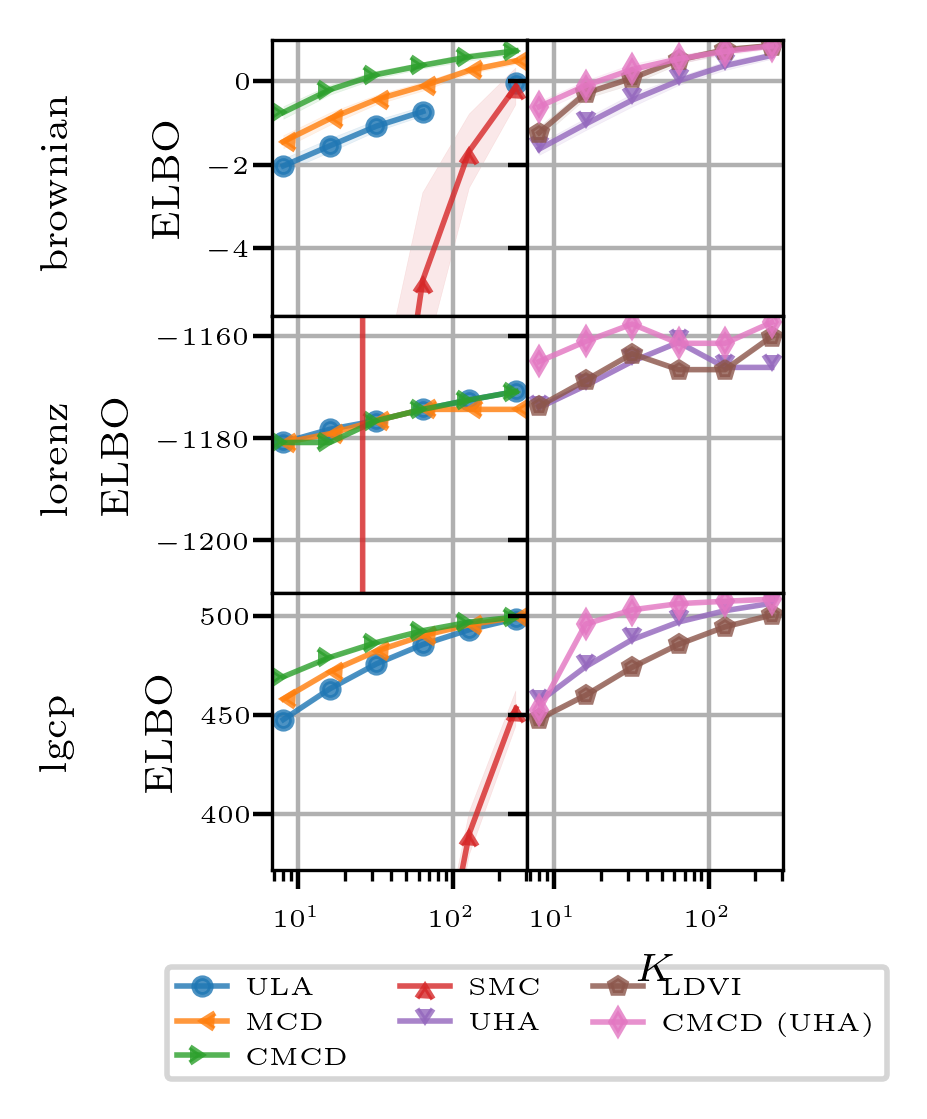

In [91]:
# Define the list of boundmodes and models to plot
from math import e
from re import A


boundmodes_to_plot_1st = ['MCD_ULA', 'MCD_ULA_sn', 'MCD_CAIS_sn', 'smc']
boundmodes_to_plot_2nd = ['UHA', 'MCD_U_a-lp-sn', 'MCD_CAIS_UHA_sn']

models_to_plot = ['brownian', 'lorenz', 'lgcp']

# models_to_plot = ['log_sonar', 'log_ionosphere', 'seeds']


legend_names = {'MCD_ULA': 'ULA', 'MCD_ULA_sn': 'MCD', 'MCD_CAIS_sn': 'CMCD', 'UHA': 'UHA', 'MCD_U_a-lp-sn': 'LDVI', 'MCD_CAIS_UHA_sn': 'CMCD (UHA)', 'smc': 'SMC'}
# Create a subplot for each model
fig, axs = plt.subplots(len(models_to_plot), 2, figsize=(0.3 * text_width, 0.5 * text_width), dpi=400, sharey='row', sharex='col')

plt.subplots_adjust(wspace=0, hspace=0)
# Iterate over each model and plot the elbo_final values for each nbridges value
for i, model in enumerate(models_to_plot):
    all_elbos = []
    # Filter the df_new DataFrame to only include the given boundmodes and model
    
    for j, boundmode in enumerate(boundmodes_to_plot_1st):

        if boundmode == 'smc':
            elbos, elbos_std = [], []
            for nbridge in sorted(unique_nbridges):
                elbos.append(result[model][nbridge]['mean'])
                elbos_std.append(result[model][nbridge]['std'])
                # all_elbos.append(result[model][nbridge]['mean'])
        else:
            df_filtered = df_new[(df_new['boundmode'] == boundmode) & (df_new['model'] == model)]
            
            # Plot the elbo_final values for each nbridges value
            elbos, elbos_std = [], []
            for nbridge in sorted(unique_nbridges):
                df_nbridge = df_filtered[df_filtered['nbridges'] == nbridge]

                print(boundmode, model, df_nbridge['elbo_final'].values)
                if df_nbridge['elbo_final'].values.size == 0:
                    if elbos:
                        elbos.append(elbos[-1])
                        elbos_std.append(elbos_std[-1])
                    else:
                        elbos.append(np.nan)
                        elbos_std.append(0)
                    continue
                elif df_nbridge['elbo_final'].values.size > 1:
                    elbo_val_id = np.argmax(df_nbridge['elbo_final'].values)
                    elbo_val = df_nbridge['elbo_final'].values[elbo_val_id]
                    elbo_std_val = df_nbridge['elbo_final_std'].values[elbo_val_id]
                    # print(elbo_val, elbo_std_val)
                    elbos.append(elbo_val)
                    elbos_std.append(elbo_std_val)
                    all_elbos.append(elbo_val)
                else:
                    elbos.append(df_nbridge['elbo_final'].values[-1])
                    elbos_std.append(df_nbridge['elbo_final_std'].values[-1])
                    all_elbos.extend(df_nbridge['elbo_final'].values)
        
        # elbos = np.array([x[0] if isinstance(x, np.array) else x for x in elbos]).ravel()
        # elbos_std = np.array([x[0] if isinstance(x, np.array) else x for x in elbos_std]).ravel()
        elbos, elbos_std = np.squeeze(np.array(elbos)), np.squeeze(np.array(elbos_std))
        print(elbos.shape, elbos_std.shape)
        print(elbos, elbos_std)
        # axs[i].plot(sorted(unique_nbridges), elbos, color=c[j], marker=markerlist[j], label=legend_names[boundmode])
        errorfill(sorted(unique_nbridges), elbos, 2 * elbos_std, 
                  color=c[j], alpha_fill=0.1, line_alpha=0.8,
                  ax=axs[i][0], lw=1, linestyle='-', 
                  fill_linewidths=0.1, marker=markerlist[j], markersize=3, 
                  label=legend_names[boundmode])
    # axs[i].plot(df_filtered['nbridges'], df_filtered['elbo_final'], color=c[i], marker=markerlist[i])
    
    # Set the title and y-axis label for the subplot
    # axs[i][0].set_title(model)
    plt.figtext(-0.2, 0.25 + 0.25 * i, models_to_plot[-1 - i], rotation=90, va='center', ha='center')

    # if i == 0:
        # handles, labels = axs[0][-1].get_legend_handles_labels()
    # axs[0][0].legend(loc='lower center', ncol=3, bbox_to_anchor=(1, -1.5))
    axs[i][0].grid(0.3, zorder=0)
    if i == 2:
        axs[i][0].set_xticks([8, 32, 64, 128, 256])
    else:
        axs[i][0].set_xticklabels([])
        axs[i][0].set_xticks([])

    axs[i][0].set_ylabel(r'ELBO')
    
    for j, boundmode in enumerate(boundmodes_to_plot_2nd):
        df_filtered = df_new[(df_new['boundmode'] == boundmode) & (df_new['model'] == model)]
        
        # Plot the elbo_final values for each nbridges value
        elbos, elbos_std = [], []
        for nbridge in sorted(unique_nbridges):
            df_nbridge = df_filtered[df_filtered['nbridges'] == nbridge]

            print(boundmode, model, df_nbridge['elbo_final'].values)
            if df_nbridge['elbo_final'].values.size == 0:
                if elbos:
                    elbos.append(elbos[-1])
                    elbos_std.append(elbos_std[-1])
                else:
                    elbos.append(np.nan)
                    elbos_std.append(0)
                continue
            elif df_nbridge['elbo_final'].values.shape[0] > 1:
                elbo_val_id = np.argmax(df_nbridge['elbo_final'].values)
                elbo_val = df_nbridge['elbo_final'].values[elbo_val_id]
                elbo_std_val = df_nbridge['elbo_final_std'].values[elbo_val_id]
                elbos.append(elbo_val)
                elbos_std.append(elbo_std_val)
                all_elbos.append(elbo_val)
            else:
                elbos.append(df_nbridge['elbo_final'].values[-1])
                elbos_std.append(df_nbridge['elbo_final_std'].values[-1])
                all_elbos.extend(df_nbridge['elbo_final'].values)
        
        # elbos_final = [x if np.isscalar(elbos) else x[0] for x in elbos]
        # elbos_std_final = [x if np.isscalar(elbos_std) else x[0] for x in elbos_std]
        elbos, elbos_std = np.squeeze(np.array(elbos)), np.squeeze(np.array(elbos_std))
        print(elbos, elbos_std)
        # axs[i].plot(sorted(unique_nbridges), elbos, color=c[j], marker=markerlist[j], label=legend_names[boundmode])
        errorfill(sorted(unique_nbridges), elbos, 2 * elbos_std, 
                  color=c[j+4], alpha_fill=0.1, line_alpha=0.8,
                  ax=axs[i][1], lw=1, linestyle='-', 
                  fill_linewidths=0.1, marker=markerlist[j+4], markersize=3, 
                  label=legend_names[boundmode])
        if i == 2:

            axs[i][1].set_xlabel(r'$K$')
    
    all_elbos = np.nan_to_num(np.array(all_elbos))
    global_min, global_max = np.min(all_elbos), np.max(all_elbos)
    
    axs[i][0].set_ylim(global_min - 1.25 * (global_max - global_min), global_max + 0.05 * (global_max - global_min))
    axs[i][1].set_ylim(global_min - 1.25 * (global_max - global_min), global_max + 0.05 * (global_max - global_min))
    # axs[i][0].set_yscale('log')


    if i == 2:
        axs[i][1].set_xticks([8, 32, 64, 128, 256])
    else:
        axs[i][1].set_xticklabels([])

    # axs[i].plot(df_filtered['nbridges'], df_filtered['elbo_final'], color=c[i], marker=markerlist[i])
    
    # Set the title and y-axis label for the subplot
    # axs[1][i].set_title(model)
    if i == 0:
        handles, labels = axs[1][-1].get_legend_handles_labels()
    # axs[1][0].legend(loc='lower center', ncol=3)
    axs[i][1].grid(0.3, zorder=0)
    axs[i][1].set_xticks([8, 32, 64, 128, 256])
    axs[i][0].tick_params(axis='y', which='major', pad=0)
    axs[i][1].tick_params(axis='y', which='major', pad=0)


    axs[i][0].set_xscale('log')
    axs[i][1].set_xscale('log')

h1, l1 = axs[0][0].get_legend_handles_labels()
h2, l2 = axs[0][1].get_legend_handles_labels()
axs[1][1].legend(h1+h2, l1+l2, loc='lower center', ncol=3, bbox_to_anchor=(0, -1.8))

# Set the x-axis label for the last subplot
# axs[-1].set_xlabel('nbridges')

# Show the plot
# plt.tight_layout()
plt.savefig('simple.pdf', bbox_inches='tight')
plt.show()


MCD_ULA brownian [0.29002711]
MCD_ULA brownian [0.67817181]
MCD_ULA brownian [0.64577347]
MCD_ULA brownian [0.77213889]
MCD_ULA brownian [nan]
MCD_ULA brownian [1.06684065]
(6,) (6,)
[0.29002711 0.67817181 0.64577347 0.77213889        nan 1.06684065] [0.59041977 0.71993256 0.37286291 0.36162886        nan 0.31911361]
MCD_ULA_sn brownian [0.58883071]
MCD_ULA_sn brownian [0.88019317]
MCD_ULA_sn brownian [0.8385483]
MCD_ULA_sn brownian [0.98023397]
MCD_ULA_sn brownian [1.17067087]
MCD_ULA_sn brownian [1.15235507]
(6,) (6,)
[0.58883071 0.88019317 0.8385483  0.98023397 1.17067087 1.15235507] [0.47379175 0.73910969 0.21913967 0.30174524 0.24157268 0.16883714]
MCD_CAIS_sn brownian [0.89876789]
MCD_CAIS_sn brownian [1.05128551]
MCD_CAIS_sn brownian [1.06689]
MCD_CAIS_sn brownian [1.10563874]
MCD_CAIS_sn brownian [1.18016458]
MCD_CAIS_sn brownian [1.16477942]
(6,) (6,)
[0.89876789 1.05128551 1.06689    1.10563874 1.18016458 1.16477942] [0.35659772 0.42808932 0.13251138 0.15629238 0.1465414  0.0

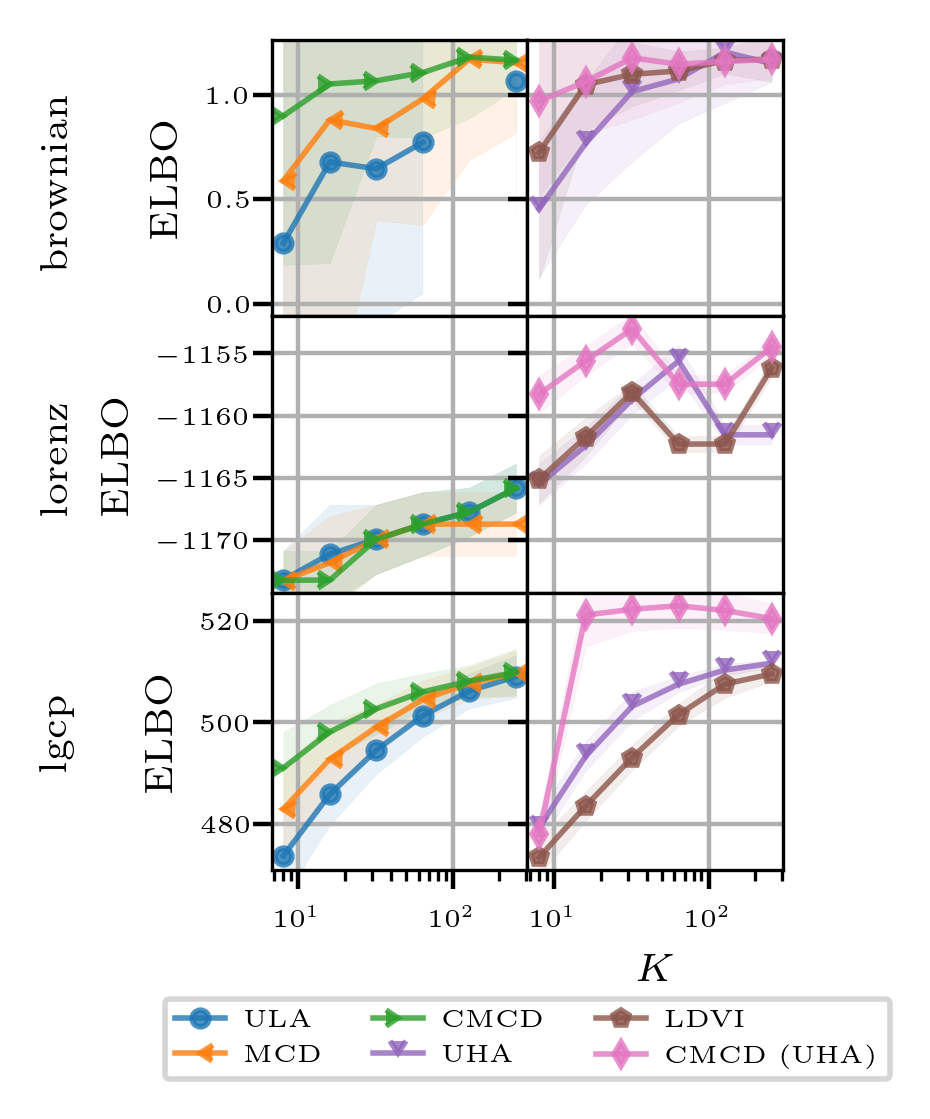

In [79]:
# Define the list of boundmodes and models to plot
from math import e
from re import A


boundmodes_to_plot_1st = ['MCD_ULA', 'MCD_ULA_sn', 'MCD_CAIS_sn']
boundmodes_to_plot_2nd = ['UHA', 'MCD_U_a-lp-sn', 'MCD_CAIS_UHA_sn']

models_to_plot = ['brownian', 'lorenz', 'lgcp']

# models_to_plot = ['log_sonar', 'log_ionosphere', 'seeds']


legend_names = {'MCD_ULA': 'ULA', 'MCD_ULA_sn': 'MCD', 'MCD_CAIS_sn': 'CMCD', 'UHA': 'UHA', 'MCD_U_a-lp-sn': 'LDVI', 'MCD_CAIS_UHA_sn': 'CMCD (UHA)', 'smc': 'SMC'}
# Create a subplot for each model
fig, axs = plt.subplots(len(models_to_plot), 2, figsize=(0.3 * text_width, 0.5 * text_width), dpi=400, sharey='row', sharex='col')

plt.subplots_adjust(wspace=0, hspace=0)
# Iterate over each model and plot the elbo_final values for each nbridges value
for i, model in enumerate(models_to_plot):
    all_elbos = []
    # Filter the df_new DataFrame to only include the given boundmodes and model
    
    for j, boundmode in enumerate(boundmodes_to_plot_1st):

        if boundmode == 'smc':
            elbos, elbos_std = [], []
            for nbridge in sorted(unique_nbridges):
                elbos.append(result[model][nbridge]['mean'])
                elbos_std.append(result[model][nbridge]['std'])
                # all_elbos.append(result[model][nbridge]['mean'])
        else:
            df_filtered = df_new[(df_new['boundmode'] == boundmode) & (df_new['model'] == model)]
            
            # Plot the elbo_final values for each nbridges value
            elbos, elbos_std = [], []
            for nbridge in sorted(unique_nbridges):
                df_nbridge = df_filtered[df_filtered['nbridges'] == nbridge]

                print(boundmode, model, df_nbridge['final_ln_Z'].values)
                if df_nbridge['final_ln_Z'].values.size == 0:
                    if elbos:
                        elbos.append(elbos[-1])
                        elbos_std.append(elbos_std[-1])
                    else:
                        elbos.append(np.nan)
                        elbos_std.append(0)
                    continue
                elif df_nbridge['final_ln_Z'].values.size > 1:
                    elbo_val_id = np.argmax(df_nbridge['final_ln_Z'].values)
                    elbo_val = df_nbridge['final_ln_Z'].values[elbo_val_id]
                    elbo_std_val = df_nbridge['final_ln_Z_std'].values[elbo_val_id]
                    # print(elbo_val, elbo_std_val)
                    elbos.append(elbo_val)
                    elbos_std.append(elbo_std_val)
                    all_elbos.append(elbo_val)
                else:
                    elbos.append(df_nbridge['final_ln_Z'].values[-1])
                    elbos_std.append(df_nbridge['final_ln_Z_std'].values[-1])
                    all_elbos.extend(df_nbridge['final_ln_Z'].values)
        
        # elbos = np.array([x[0] if isinstance(x, np.array) else x for x in elbos]).ravel()
        # elbos_std = np.array([x[0] if isinstance(x, np.array) else x for x in elbos_std]).ravel()
        elbos, elbos_std = np.squeeze(np.array(elbos)), np.squeeze(np.array(elbos_std))
        print(elbos.shape, elbos_std.shape)
        print(elbos, elbos_std)
        # axs[i].plot(sorted(unique_nbridges), elbos, color=c[j], marker=markerlist[j], label=legend_names[boundmode])
        errorfill(sorted(unique_nbridges), elbos, 2 * elbos_std, 
                  color=c[j], alpha_fill=0.1, line_alpha=0.8,
                  ax=axs[i][0], lw=1, linestyle='-', 
                  fill_linewidths=0.1, marker=markerlist[j], markersize=3, 
                  label=legend_names[boundmode])
    # axs[i].plot(df_filtered['nbridges'], df_filtered['elbo_final'], color=c[i], marker=markerlist[i])
    
    # Set the title and y-axis label for the subplot
    # axs[i][0].set_title(model)
    plt.figtext(-0.2, 0.25 + 0.25 * i, models_to_plot[-1 - i], rotation=90, va='center', ha='center')

    # if i == 0:
        # handles, labels = axs[0][-1].get_legend_handles_labels()
    # axs[0][0].legend(loc='lower center', ncol=3, bbox_to_anchor=(1, -1.5))
    axs[i][0].grid(0.3, zorder=0)
    if i == 2:
        axs[i][0].set_xticks([8, 32, 64, 128, 256])
    else:
        axs[i][0].set_xticklabels([])
        axs[i][0].set_xticks([])

    axs[i][0].set_ylabel(r'ELBO')
    
    for j, boundmode in enumerate(boundmodes_to_plot_2nd):
        df_filtered = df_new[(df_new['boundmode'] == boundmode) & (df_new['model'] == model)]
        
        # Plot the elbo_final values for each nbridges value
        elbos, elbos_std = [], []
        for nbridge in sorted(unique_nbridges):
            df_nbridge = df_filtered[df_filtered['nbridges'] == nbridge]

            print(boundmode, model, df_nbridge['final_ln_Z'].values)
            if df_nbridge['final_ln_Z'].values.size == 0:
                if elbos:
                    elbos.append(elbos[-1])
                    elbos_std.append(elbos_std[-1])
                else:
                    elbos.append(np.nan)
                    elbos_std.append(0)
                continue
            elif df_nbridge['final_ln_Z'].values.shape[0] > 1:
                elbo_val_id = np.argmax(df_nbridge['final_ln_Z'].values)
                elbo_val = df_nbridge['final_ln_Z'].values[elbo_val_id]
                elbo_std_val = df_nbridge['final_ln_Z_std'].values[elbo_val_id]
                elbos.append(elbo_val)
                elbos_std.append(elbo_std_val)
                all_elbos.append(elbo_val)
            else:
                elbos.append(df_nbridge['final_ln_Z'].values[-1])
                elbos_std.append(df_nbridge['final_ln_Z_std'].values[-1])
                all_elbos.extend(df_nbridge['final_ln_Z'].values)
        
        # elbos_final = [x if np.isscalar(elbos) else x[0] for x in elbos]
        # elbos_std_final = [x if np.isscalar(elbos_std) else x[0] for x in elbos_std]
        elbos, elbos_std = np.squeeze(np.array(elbos)), np.squeeze(np.array(elbos_std))
        print(elbos, elbos_std)
        # axs[i].plot(sorted(unique_nbridges), elbos, color=c[j], marker=markerlist[j], label=legend_names[boundmode])
        errorfill(sorted(unique_nbridges), elbos, elbos_std, 
                  color=c[j+4], alpha_fill=0.1, line_alpha=0.8,
                  ax=axs[i][1], lw=1, linestyle='-', 
                  fill_linewidths=0.1, marker=markerlist[j+4], markersize=3, 
                  label=legend_names[boundmode])
        if i == 2:

            axs[i][1].set_xlabel(r'$K$')
    
    all_elbos = np.nan_to_num(np.array(all_elbos))
    global_min, global_max = np.min(all_elbos), np.max(all_elbos)
    
    axs[i][0].set_ylim(global_min -0.05 * (global_max - global_min), global_max + 0.05 * (global_max - global_min))
    axs[i][1].set_ylim(global_min - 0.05 * (global_max - global_min), global_max + 0.05 * (global_max - global_min))
    # axs[i][0].set_yscale('log')


    if i == 2:
        axs[i][1].set_xticks([8, 32, 64, 128, 256])
    else:
        axs[i][1].set_xticklabels([])

    # axs[i].plot(df_filtered['nbridges'], df_filtered['elbo_final'], color=c[i], marker=markerlist[i])
    
    # Set the title and y-axis label for the subplot
    # axs[1][i].set_title(model)
    if i == 0:
        handles, labels = axs[1][-1].get_legend_handles_labels()
    # axs[1][0].legend(loc='lower center', ncol=3)
    axs[i][1].grid(0.3, zorder=0)
    axs[i][1].set_xticks([8, 32, 64, 128, 256])
    axs[i][0].tick_params(axis='y', which='major', pad=0)
    axs[i][1].tick_params(axis='y', which='major', pad=0)


    axs[i][0].set_xscale('log')
    axs[i][1].set_xscale('log')

h1, l1 = axs[0][0].get_legend_handles_labels()
h2, l2 = axs[0][1].get_legend_handles_labels()
axs[1][1].legend(h1+h2, l1+l2, loc='lower center', ncol=3, bbox_to_anchor=(0, -1.8))

# Set the x-axis label for the last subplot
# axs[-1].set_xlabel('nbridges')

# Show the plot
# plt.tight_layout()
plt.savefig('simple.pdf', bbox_inches='tight')
plt.show()
